In [1]:
#Reads in full photometric and spec object catalog cleaned using New_0910_cats notebook
#Rotation and conversion of objects to test different binning methods
#Outputs groupbys of full cat_all to pickle for use in CMD plotting programs
#Added KS tests, error on median on CMD/CSMDs for Merger Front and Merger Back
#Also includes star formation rate calculations by region by reading in EW measurement catalogs
#L_TIR data analysis was added onto the end of the New_0910_cats notebook because I had to merge the new catalog
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import sys,os
%pylab inline
import cluster_tools.profiles as profiles
import cluster_tools.CAT as CAT
import cluster_tools.tools as tools
import cluster_tools.cosmo as cosmos
import cluster_tools.Cluster_functs as t
reload(t)
import pickle
#from scipy.stats import ks_2samp
from scipy.stats import ks_2samp,kstest
#import numpy
import scipy.integrate
import mpld3
from IPython.display import Image, display
from sklearn.utils import resample
import cluster_tools.scic_dist_functions as scic_dist
#Use this to grab and display composites from folder
#listOfImageNames = ['/path/to/images/1.png',
#                    '/path/to/images/2.png']
#for imageName in listOfImageNames:
#    display(Image(filename=imageName))
from mpld3 import plugins, utils
#mpld3.enable_notebook()


Populating the interactive namespace from numpy and matplotlib
3!= 6.0 = e^(ln[gamma(4)]) = 6
120.0
4.03291461127e+26
24.0
0.994376487882
0.00562351211827
1.0
0.112754082424
0.520357177501
0.842681743299
0.999999999998
-0.112754082424
-0.520357177501
-0.842681743299
-0.999999999998
36.4981663726
0.999329074744


In [15]:
#Based on MPLD3 function by Jake VanderPlas
#The plugin allows for interactive plots
#The second function creates number density .fits files that I use to make contours for plots and analysis
#You can ignore these unless you are insatiably curious
class LinkedView(plugins.PluginBase):
    """A simple plugin showing how multiple axes can be linked"""

    JAVASCRIPT = """
    mpld3.register_plugin("linkedview", LinkedViewPlugin);
    LinkedViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LinkedViewPlugin.prototype.constructor = LinkedViewPlugin;
    LinkedViewPlugin.prototype.requiredProps = ["idpts", "idline", "data"];
    LinkedViewPlugin.prototype.defaultProps = {}
    function LinkedViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LinkedViewPlugin.prototype.draw = function(){
      var pts = mpld3.get_element(this.props.idpts);
      var line = mpld3.get_element(this.props.idline);
      var data = this.props.data;

      function mouseover(d, i){
        line.data = data[i];
        line.elements().transition()
            .attr("d", line.datafunc(line.data))
            .style("stroke", this.style.fill);
      }
      pts.elements().on("mouseover", mouseover);
    };
    """

    def __init__(self, points, line, linedata):
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "linkedview",
                      "idpts": utils.get_id(points, suffix),
                      "idline": utils.get_id(line),
                      "data": linedata}

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #E0E0E0 ;
  background-color: #663399;
}
td
{
  background-color: #CCCCFF;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: left;
}
"""

#def numberdensity(catalog, rabin, prefix, weights=None):
def numberdensity(catalog, rabin, prefix, weights=False):
    '''
    Ali Edit: This version is extended by half on each side in RA and Dec
    Resolution must be doubled (rabin=rabin*2 or ~2000 from 1000)
    Creates a 2D fits map which is essentially a 2D histogram of the galaxies.
    Input:
    catalog 
    rabin = [integer] the number of bins along the ra axis for the 2D
        histogram, also the number of pixels along the ra axis in the
        fits file. The decbin is calculated such that the 2D bins and pixels
        will be aproximately square.
    Output:
    prefix+'_numberdensity.fits' = a galaxy number density fits file of size xpix by ypix  
    '''

    import astropy.io.fits as pyfits
    ### CALCULATIONS ################
    # Read in the catalog data and header

    cat = catalog

    racol = numpy.array(cat['alpha'])

    deccol = numpy.array(cat['delta']) 
    
    if weights==True:
        
        weight = numpy.array(cat['weight']) 

    # Calculate the number of bins along the dec axis

    dec_min = numpy.min(deccol)-0.055

    dec_max = numpy.max(deccol)+0.055

    dec_mean = (dec_max + dec_min) / 2 * numpy.pi / 180.0 #radians
    
    ra_min = numpy.min(racol)-0.055/numpy.cos(dec_mean)

    ra_max = numpy.max(racol)+0.055/numpy.cos(dec_mean)

    # determine decbin such that the pixels are approximately square

    decbin = rabin*(dec_max-dec_min)//((ra_max-ra_min)*numpy.cos(dec_mean))

    # create the pixel/bin edge arrays

    ra_binwidth = (ra_max-ra_min)/rabin

    dec_binwidth = (dec_max-dec_min)/decbin

    ra_edge = numpy.arange(ra_min,ra_max+ra_binwidth,ra_binwidth)

    dec_edge = numpy.arange(dec_min,dec_max+dec_binwidth,dec_binwidth)

    # due to possible rounding issues it is necessary to redefine decbin to

    # match dec_edge

    decbin = numpy.size(dec_edge)-1

    #create the 2D histogram    
    if weights==True:
        print 'with weights'
        h, tmp_edge, tmp_edge = numpy.histogram2d(deccol,racol,
    
                          bins=(dec_edge,ra_edge), weights=weight,normed=True)
    else:

        h, tmp_edge, tmp_edge = numpy.histogram2d(deccol,racol,
    
                          bins=(dec_edge,ra_edge))
    #numpy.histogram2d
    # h, tmp_edge, tmp_edge = numpy.histogram2d(cat[:,deccol],cat[:,racol],
#                                                 bins=(dec_edge,ra_edge),weights=weight)
#if weight != None:
#        weight = cat[:,key[weight]]
#weight = [string] the ttype name of the weight column in catalog, e.g. luminosity
    #Create the fits file

    H = h

    hdu = pyfits.PrimaryHDU(numpy.float32(H))    

    # Calculate the wcs CR**** for the fits header    

    xscale = (ra_max - ra_min) * numpy.cos(dec_mean) / rabin

    yscale = (dec_max - dec_min) / decbin

    crval1 = (ra_max - ra_min) / 2 + ra_min

    crval2 = (dec_max - dec_min) / 2 + dec_min

    crpix1 = rabin / 2

    crpix2 = decbin / 2

    # Apply the wcs to the fits header

    hdu.header.update('ctype1', 'RA---TAN')

    hdu.header.update('ctype2', 'DEC--TAN')

    hdu.header.update('crval1', crval1)

    hdu.header.update('crval2', crval2)

    hdu.header.update('crpix1', crpix1)

    hdu.header.update('crpix2', crpix2)

    hdu.header.update('cd1_1',xscale)

    hdu.header.update('cd1_2',0)

    hdu.header.update('cd2_1',0)

    hdu.header.update('cd2_2',yscale)

    filename = prefix+'_numberdensity'

    hdu.writeto(filename+'.fits',clobber=True)

In [2]:
#%pylab inline
#Cosmological constants calculate from fundamental equations, mostly using other programs
#Centroids are calculated statistically using several methods and aperatures
c = 3*10**5 #Units km/s
z=zC=1.105
rvirB=1.01207064831
rvirA=0.820350458861
#rvir = r200/1.14
r200A=rvirA*1.14
r200B=rvirB*1.14
zCB= 1.1024208 #mean redshift B
zCA= 1.1003972 #mean redshift A
sigmaA, sigmaA_err=681.2,170.1
sigmaB, sigmaB_err=840.4,244.0
#CENTROIDS
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
M200A, M200B = 2.91546371993e+14,5.47446715836e+14 #5.47446715836, 2.91546371993

filepath='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/'
cat_all=pd.read_csv('/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cat_all_PG.tab',sep='\t')
#cat_all.id=cat_all.id.astype('int64')
cat_gq=cat_all

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (89,90,91,101,102,107,108,114) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#reduce cat for now to only mecessary mags and other properties for easier manipulation
#This reindexes everything
cat_gq=pd.concat([cat_gq.loc[:,'id':'dec'], cat_gq.loc[:,'star':]],axis=1)
cat_gq.set_index(['id','z_group','q_group'],drop=False,inplace=True)
cat_gq=cat_gq[cat_gq.region_PG.notnull()] #remove photometric objects outside slitmask area for accurate completeness statistics

Populating the interactive namespace from numpy and matplotlib


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


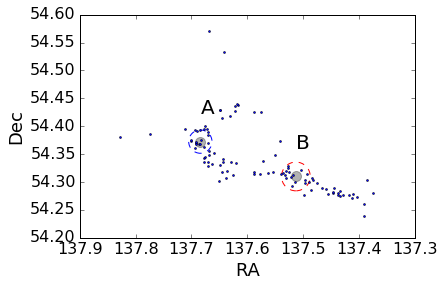

In [4]:
%pylab inline
#All points, unrotated
#%pylab inline #The circles only work if you do this command but then you can't interact with plots for the rest of the doc
py.scatter(raA,decA, marker='o', c='k', s=100, alpha=0.3)
py.text(raA,decA+.05, 'A',fontsize=20)
py.scatter(raB,decB, marker='o', c='k', s=100, alpha=0.3)
py.text(raB,decB+.05, 'B',fontsize=20)
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).ra, cat_gq.xs(['cz','high'],level=['z_group','q_group']).dec,'bo',ms=2)
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)
#Circles only draw for inline, but then can't interact with mpld3
RvA=py.Circle((raA, decA),rvirA/(cosmos.ProjectedLength(z)*60) , color='b',fill=False, ls='dashed') #B
RvB=py.Circle((raB, decB),rvirB/(cosmos.ProjectedLength(z)*60), color='r',fill=False, ls='dashed') #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
py.draw()
#py.show()
#mpld3.enable_notebook()

In [5]:
#We didn't end up using this for anything, but went with the tidal radius from the other notebook
#Interesting exercise nonetheless
#mpld3.enable_notebook()
cat_gq['LFC_RA']=cat_gq.ra
cat_gq['LFC_dec']=cat_gq.dec
#This is so can apply slices to members subsets, or do groupby radially cut composites
#to not exclude members from other cluster, do (members within A| members within B)
#do distance cut, for A and B centers, could change to zA, zB
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
f=lambda a,b: tools.angdist(a,b,raA,decA)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raA,decA)*60*cosmos.ProjectedLength(z)
cat_gq['dA']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dAMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
f=lambda a,b: tools.angdist(a,b,raB,decB)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raB,decB)*60*cosmos.ProjectedLength(z)
cat_gq['dB']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dBMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
#blah=py.hist(cat_gq.dAMpc[cat_gq.dAMpc<2*rvirA],bins=10)
del_cA, rsA, r200A_will, csA, rhosA = profiles.nfwparam_extended(M200A/1e14,z,h_scale=0.7,Om=0.3,Ol=0.70,Or=0.0)
del_cB, rsB, r200B_will, csB, rhosB = profiles.nfwparam_extended(M200B/1e14,z,h_scale=0.7,Om=0.3,Ol=0.70,Or=0.0)
print del_cA, rsA, r200A_will, csA, rhosA #rho M_sun/Mpc^3, r200 Mpc
print del_cB, rsB, r200B_will, csB, rhosB
R=10*1e-3 #10kpc in Mpc (~0.01 Mpc)radius galaxy reasonable, ellipticals range 0.3-100+kpc (eventually half light radius of each)
m=1e12 #units Msun. Milky way is .8-1.5e12. ellipticals can be e7-e13
G = 6.673*10**-11 # m**3/kg/s**2, or  N*m**2 / kg**2
c = 3e8 #speed of light m/s
kginMsun = 1.98892*10**30 # kg in a solar mass
minMpc = 3.08568025*10**22 # m in a Megaparsec            
r2d = 180/numpy.pi # radians to degrees conversion factor
FtoNewtons = kginMsun**2 / minMpc**2
print FtoNewtons, G
#differential force from cluster A on galaxy of radius R at dAMpc (units!) or various R_N's for equipotentials
#define functions then apply for F_At and F_Bt
#F_AMenc=4.*np.pi *rhos*rs**3*( np.log( (rs+r)/rs ) - R_N/(r+rs) )
cat_gq['M_A']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
cat_gq['M_B']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
cat_gq['F_tAB']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
rhos,rs=rhosA,rsA
#constants R is in Mpc, m is in M_sun.
func_Menc= lambda r: 4.*np.pi *rhos*rs**3*( np.log( (rs+r)/rs ) - r/(r+rs) ) #enclosed mass at distance r from cluster core of A or B
#Units: Menc is in Msun (or 1e30 kg, sanity check cluster is 1*10**14 solar mass, (Will reports in 10^14M*)
func_Ft=lambda r,M: G*M*m*( 1/r**2. - 1/(r+R)**2. )*FtoNewtons #Force in galaxy radius R a distance r from clust
cat_gq['M_A']=map(func_Menc, cat_gq['dAMpc']) #Msun
cat_gq['F_A']=map(func_Ft, cat_gq['dAMpc'], cat_gq['M_A'])
#diff force from cluster B on galaxy radius R at distance from cluster core dBMpc
rhos,rs=rhosB,rsB
func_Menc= lambda r: 4.*np.pi *rhos*rs**3*( np.log( (rs+r)/rs ) - r/(r+rs) ) #enclosed mass at distance r from cluster core of A or B
func_Ft=lambda r,M: G*M*m*( 1/r**2. - 1/(r+R)**2. )*FtoNewtons #Force in galaxy radius R a distance r from clust
cat_gq['M_B']=map(func_Menc, cat_gq['dBMpc'])
cat_gq['F_B']=map(func_Ft, cat_gq['dBMpc'],cat_gq['M_B'])
#Should I weight the force again? 
func_Ftot=lambda a,b: a+b
cat_gq['F_tAB']=map(func_Ftot, cat_gq['F_A'],cat_gq['F_B'])
print 'F_tAB, F_tA, F_tB',cat_gq['F_tAB'][cat_gq.q_group=='high'].mean(),cat_gq['F_A'][cat_gq.q_group=='high'].mean(),cat_gq['F_B'][cat_gq.q_group=='high'].mean()
print cat_gq['F_tAB'][cat_gq.q_group=='high'].describe()#, cat_gq['M_A'][cat_gq.q_group=='high'].describe()

2318.50605132 0.330203245275 0.901056037111 2.72879219089 1.10291455428e+15
2077.46791679 0.429514683778 1.11163754197 2.58812465313 9.88252586257e+14
4.15463416593e+15 6.673e-11
F_tAB, F_tA, F_tB 2.33383090073e+30 1.21222749786e+30 1.12160340287e+30
count    7.020000e+02
mean     2.333831e+30
std      8.578009e+30
min      2.298833e+28
25%      2.009249e+29
50%      5.630660e+29
75%      1.180907e+30
max      1.447349e+32
Name: F_tAB, dtype: float64


Galaxies within 2 Rvir for A and B 28 35


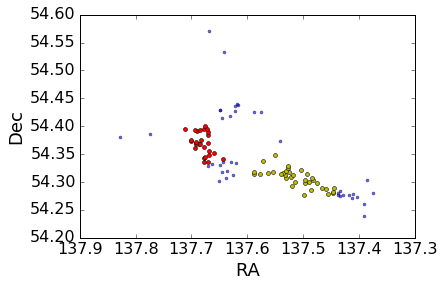

In [6]:
py.close()
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq.xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'bo',ms=3,alpha=.6)
py.plot(cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'ro',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'yo',ms=4)
#py.scatter(cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,s=cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).F_tAB.values/10e29)
print 'Galaxies within 2 Rvir for A and B',len(cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_RA),len(cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_RA)
#Note that a selection as wide as 2 Rvir for cluster A excludes the group that could possibly be infalling
#currently only 15 galaxies within rvirA which is less than 1Mpc
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)
#A number of objects are outside the virial radii of both clusters
#So we want to see if they are 

Galaxies within 1.5 Rvir for A and B 25 27
Galaxies within 0.5 Rvir for A and B 8 9
Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B 17 18


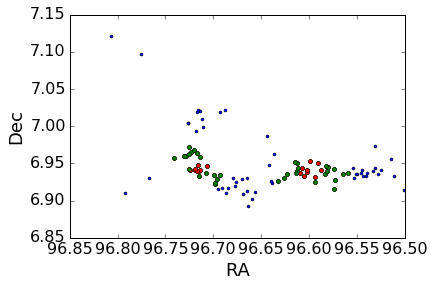

In [7]:
#Looking at data and key radii, getting a feel for how to define the system which will be essential
#Precurser for investigation into binning method and 
#We try the rotation of system to make linear bins along the axis, comparing the merger front to back
py.close('all')
#%pylab inline
#REPEAT MPLD3 here to re-instate
#mpld3.enable_notebook()
#cat_gq['rax']=cat_gq.LFC_RA*np.cos(np.deg2rad(cat_gq.LFC_DEC))
cat_gq['rax']=cat_gq.LFC_RA*np.cos(np.deg2rad(54.33))
theta=30
theta=np.deg2rad(theta)
cat_gq['xprime'] = np.cos(theta)*cat_gq.rax +np.sin(theta)*cat_gq.LFC_DEC
cat_gq['yprime'] = -np.sin(theta)*cat_gq.rax+np.cos(theta)*cat_gq.LFC_DEC
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=3)
py.plot(cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=4)
print 'Galaxies within 1.5 Rvir for A and B',len(cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime)
py.plot(cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=4)
print 'Galaxies within 0.5 Rvir for A and B',len(cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime)
py.plot(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=4)
py.plot(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=4)
print 'Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B',len(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime)
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)


In [8]:
#TRANSLATE SINGLE POINT
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
print tools.angdist(raA,decA,raB,decB)*60 ,'arcmin angular distance'
print tools.angdist(raA,decA,raB,decB)*60*60 ,'arcsec angular distance'
print tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z) ,'Mpc'
print tools.angdist(raA,decA,raB,decB)*60 /(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)),'arcmin/Mpc'
print 12*tools.angdist(raA,decA,raB,decB)*60 /(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)),'8Mpc*arcmin/Mpc'
ra, dec = raA, decA
rax=ra*np.cos(np.deg2rad(54.33))
rot=np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
x= np.array([ [rax],[dec] ])
np.dot(rot,x)
print 'New RA',np.dot(rot,x)[0],'New DEC',np.dot(rot,x)[1]


7.06361424076 arcmin angular distance
423.816854446 arcsec angular distance
4.62259744875 Mpc
1.528061727 arcmin/Mpc
18.336740724 8Mpc*arcmin/Mpc
New RA [ 96.71567791] New DEC [ 6.94500187]


In [9]:
#TRANSLATE MANY POINTS (NOT FOR PLOTTING BINS YET LIKE OTHER LOOP)
bins=[raA,raB]
y=[decA,decB]
ra_rots=[]
dec_rots=[] #nI think I want tuples if I can plot them...eventually
for ra,dec in zip(bins,y):
#    for dec in y:
        rax=ra*np.cos(np.deg2rad(54.33))
        x= np.array([ [rax],[dec] ])
        dec_rot=np.dot(rot ,x)[1]
        ra_rot=np.dot(rot ,x)[0]
        ra_rots.append(ra_rot[0])
        dec_rots.append(dec_rot[0])
ra_rotA, ra_rotB= ra_rots[0],ra_rots[1]

dec_rotA, dec_rotB= dec_rots[0],dec_rots[1]
print zip(np.array(ra_rots),np.array(dec_rots))

[(96.715677907798337, 6.9450018669405225), (96.598001571138923, 6.9408393658700689)]


In [10]:
#DISTANCE SCALE (can be applied to y if want to select area/height in Mpc)
#This one is based on centroids but the scale shouldn't change
dx=np.array(ra_rots)[0]-np.array(ra_rots)[1]
print dx
print tools.angdist(raA,decA,raB,decB)*60*60 #ARCSEC
print tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z) #MPC
print 'Mpc/Degree', 60*cosmos.ProjectedLength(z)
#tools.angdist(raA,decA,raB,decB)/tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)
print 'conversion scale for dx/arcsec',dx/(tools.angdist(raA,decA,raB,decB)*60*60)
print 'conversion scale for dx/Mpc',dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'conversion scale for arcsec/dx',(tools.angdist(raA,decA,raB,decB)*60*60)/dx
print 'conversion scale for Mpc/dx',(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))/dx
print 'So 4.6Mpc is 4.6Mpc*(dx/Mpc->dx)',4.6*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'So 1.01207064831 Mpc is X Mpc*(dx/Mpc->dx)',1.01207064831*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'So 0.820350458861 Mpc is X Mpc*(dx/Mpc->dx)',0.820350458861*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
#Now do this for constants
dx2Mpc=(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))/dx
dx2arcsec=(tools.angdist(raA,decA,raB,decB)*60*60)/dx
Mpc2dx=dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
arcsec2dx=dx/(tools.angdist(raA,decA,raB,decB)*60*60)
RvirA_rot=rvirA*Mpc2dx
RvirB_rot=rvirB*Mpc2dx
R200A_rot=r200A*Mpc2dx
R200B_rot=r200B*Mpc2dx
print RvirA_rot,RvirB_rot
print R200A_rot,R200B_rot #R200 is bigger...

0.117676336659
423.816854446
4.62259744875
Mpc/Degree 39.2654294914
conversion scale for dx/arcsec 0.000277658463615
conversion scale for dx/Mpc 0.0254567562856
conversion scale for arcsec/dx 3601.54697603
conversion scale for Mpc/dx 39.2823024576
So 4.6Mpc is 4.6Mpc*(dx/Mpc->dx) 0.117101078914
So 1.01207064831 Mpc is X Mpc*(dx/Mpc->dx) 0.0257640358379
So 0.820350458861 Mpc is X Mpc*(dx/Mpc->dx) 0.0208834617
0.0208834617 0.0257640358379
0.023807146338 0.0293710008552


In [11]:
#SECOND SET BINS

(3.04, 0.51, 0.51, 1.01, 0.51, 0.51, 1.87, 0.41, 0.41, 0.82, 0.41, 0.41, 2.46)
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B 17 18
Galaxies within 4.0 Mpc Rvir annulus for A and B 19
Galaxies within 3.5 Mpc Rvir annulus for A and B 10


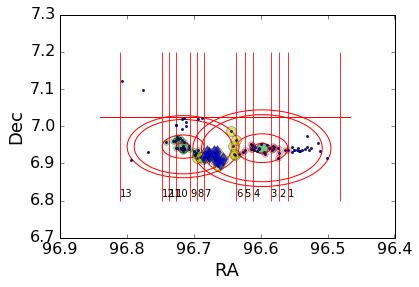

In [12]:
#VERSION COPIED CEL WITH INLINE TO VIEW
#SECOND SET BINS
#DEFINE NEW BINS
#mpld3.enable_notebook()
#%pylab inline
#This set will be bin centered on each centroid of virial radius divided by two
#Then a bin emcompassing what is left in the center...perhaps see where these meet
#Anything outside these bin ranges will be grouped accordingly, maybe to a catch-all
#A bins start at center then move left with +*RvirA*N/2
#smallest bins, maybe too small?
#binsAleft=[ra_rotA,ra_rotA+RvirA_rot/2,ra_rotA+RvirA_rot,ra_rotA+RvirA_rot*(1.5),ra_rotA+RvirA_rot*2]
#larger bins
binsAleft=[ra_rotA,ra_rotA+RvirA_rot/2,ra_rotA+RvirA_rot,ra_rotA+RvirA_rot*4]
binsBleft=[ra_rotB,ra_rotB+RvirB_rot,ra_rotB+RvirB_rot*1.5,ra_rotB+RvirB_rot*2]
binsAright=[ra_rotA-RvirA_rot,ra_rotA-RvirA_rot*1.5,ra_rotA-RvirA_rot*2]    
binsBright=[ra_rotB-RvirB_rot,ra_rotB-RvirB_rot*.5,ra_rotB-RvirB_rot*4]    
binsA=binsAleft+binsAright
binsB=binsBleft+binsBright
#bins=(np.array(bins)-RvirA_rot/4) #shifts bins to Right by RvirA_rot/2
#bins=(np.array(bins)+RvirA_rot/4) #shifts bins to LEFT by RvirA_rot/2
binsA=(np.array(binsA)+RvirA_rot/2).tolist() #shifts bins to LEFT by RvirA_rot/2
binsB=(np.array(binsB)-RvirB_rot/2).tolist() #shifts bins to RIGHT by RvirB_rot/2
bins=binsA+binsB
#print bins
bins.sort() #should make this low to high, originally low to high
#RvirA_rot=rvirA*Mpc2dx,39.2823024576, dx*dx2Mpc convert Mpx to dx in rotated reference frame
#for i in arange(len(bins)-1): print abs(bins[i]-bins[i+1])*dx2Mpc,'bin i+1',i+1
#binwMpc=[abs(bins[i]-bins[i-1])*dx2Mpc for i in arange(len(bins)-1,0,-1)] #13 to 1
#for i in arange(len(bins)-1): print i,abs(bins[i]-bins[i+1])*dx2Mpc,'bin i+1',i+1
#binwMpc=[(abs(bins[i]-bins[i+1])*dx2Mpc,i+1) for i in arange(len(bins)-1)] #1 to 13, right to left, low to high, if .sort()
binwMpc=[(round(abs(bins[i]-bins[i+1])*dx2Mpc,2),i+1) for i in arange(len(bins)-1)]#print '{:.2f}'.format(zip(*binwMpc)[0])
#binw,n = zip(*binwMpc)[0],zip(*binwMpc)[1] #zip(*binwMpc) unzipping bin width and corresponding bin number 1 indexed
print zip(*binwMpc)[0]
print zip(*binwMpc)[1]
#Goes low to high bin edge values so right to left on plot. Currently for all points
#cat_gq.info()
cat_gq.set_index(['z_group','q_group'],drop=False,inplace=True)
#%matplotlib inline
fig, ax = py.subplots()
#py.rcParams['figure.figsize'] = (20, 16)
py.rcParams['figure.figsize'] = (10, 6)
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=2,alpha=0.8)
py.plot(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=6,alpha=0.3)
py.plot(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=6,alpha=0.3)
print 'Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B',len(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime)
py.plot(cat_gq[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq[( (cat_gq.dBMpc<=4*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=10,alpha=0.5 )
print 'Galaxies within 4.0 Mpc Rvir annulus for A and B',len(cat_gq[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']) )
RvA=py.Circle((ra_rotA,dec_rotA),4.0*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),4.0*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
py.plot(cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).yprime,'bd',ms=10,alpha=0.7 )
print 'Galaxies within 3.5 Mpc Rvir annulus for A and B',len(cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']) )
py.axhline(y=7.025, xmin=cat_gq.xprime.max(), xmax=cat_gq.xprime.min(), linewidth=10, color = 'r')
py.axhline(y=7.025, xmin=cat_gq.xprime.min(), xmax=cat_gq.xprime.max(), linewidth=10, color = 'r')
RvA=py.Circle((ra_rotA,dec_rotA),3.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),3.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
RvA=py.Circle((ra_rotA,dec_rotA),1.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),1.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
RvA=py.Circle((ra_rotA,dec_rotA),0.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),0.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
#py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=3)
ymin, ymax =6.8000000000000007, 7.2000000000000011
py.scatter( ra_rotA,dec_rotA, marker='o', c='g', s=130, alpha=0.5)
py.scatter(  ra_rotB,dec_rotB, marker='o', c='g', s=130, alpha=0.5)
#bins.sort()
#currently numbers increase mono without reverse...
for i,bin in enumerate(bins):
    py.vlines(bin, ymin, ymax, linestyle='solid', linewidth=0.8, color='r' )
    if (i!=0):
        py.text(bin,ymin+0.01,str(i),color='k',fontsize='10')
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)
yplim=[7.025,7.025]
xplim=[ 96.4670770621,96.8396815522]
py.plot(xplim,yplim,'r-')
folder='Rvir_radialg4'
targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'
#py.savefig(targetdir+folder+'radec_unrot')
ax.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=2,alpha=0.8)
points=ax.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'wo',mfc='None',ms=5,alpha=0.01)
labelsp = []
#ununcomment for interactive plot
#for i in range(len(cat_gq.xs(['cz','high'],level=['z_group','q_group']))):
#    labelp=cat_gq.xs(['cz','high'],level=['z_group','q_group']).ix[[i], ['slice','slice_i','Z','ra','dec','z_group','z_group_pz','q_group']].T
#    labelp.columns = ['{0}'.format(cat_gq.xs(['cz','high'],level=['z_group','q_group']).id_phot[i])]
#    labelsp.append(str(labelp.to_html()))    
#tooltip = plugins.PointHTMLTooltip(points[0], labelsp,voffset=10, hoffset=10, css=css)
#mpld3.plugins.connect(fig, tooltip)

#Only uncomment if you have the mpld3 enable notebook uncommented
#mpld3.save_html(fig, 'RADEC_PG_full.html')
#from IPython.display import Image
#Image("img/picture.png")

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


slice_i
1           2187
10          1524
11           784
12           842
13          4457
2            406
3            452
4           1348
5            943
6           1013
7           3868
8            731
9            642
no slice    1096
dtype: int64
slice
core A           156
core B           188
infall A        1011
infall B        1360
merger back     7725
merger front    2049
unassigned      7804
dtype: int64
Using dic (zip of bins3 and labels manually spec), will not plot unassigned {'infall B': '2', 'infall A': '5', 'core B': '3', 'core A': '6', 'merger back': '1', 'merger front': '4'}
plotting merger back 1
plotting infall B 2
plotting core B 3
plotting merger front 4
plotting infall A 5
plotting core A 6
1 ['1'] ['merger back'] 28
2 ['2'] ['infall B'] 18
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 19
5 ['5'] ['infall A'] 17
6 ['6'] ['core A'] 8
7 ['7'] ['unassigned'] 3


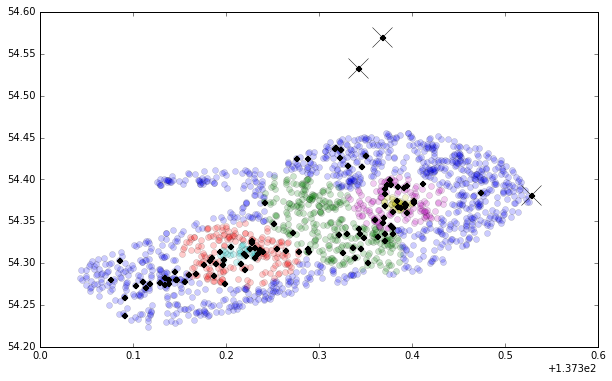

In [13]:
#This cell is a mess because I tried a few different methods of binning along the merger axis
#As a first go this made sense physically, but then we considered NFW dark matter halos are spherical
#Symmetrically it makes sense for us to consider gravitational tidal forces affecting galaxies this way
#So the bins we used on the end are as follows
folder='Rvir_radialg4'
targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'
core_condA, core_condB=(cat_gq.dAMpc<0.5*rvirA),(cat_gq.dBMpc<0.5*rvirB)
annulus_condA,annulus_condB=((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)
#print 'This will not wor if I have index of id because there are duplicates...I think groupby keeps index'
cat_gq.reset_index(inplace=True,drop=True)
grouped_xbins_i = cat_gq.groupby(pd.cut(cat_gq.xprime,bins,labels=[str(i+1) for i in arange(len(bins)-1)]))
#print grouped_xbins_i.size()
cat_gq['slice_i']=pd.Series(np.repeat(np.array('no slice'),len(cat_gq)), index=cat_gq.index)
for a in [str(i+1) for i in arange(len(bins)-1)]:
    cat_gq['slice_i'].loc[grouped_xbins_i.get_group(a).index]=a
print cat_gq.groupby('slice_i').size()
#print 'grouped_xbins_i bins now labeled by number right to left, in image'
#cat_gq[cat_gq.slice_i=='no slice'].ra.count()
#py.plot(cat_gq[cat_gq.slice_i=='no slice'].ra,cat_gq[cat_gq.slice_i=='no slice'].dec,'ro')
#py.plot(cat_gq[cat_gq.slice_i=='4'].ra,cat_gq[cat_gq.slice_i=='4'].dec,'bo')
#py.plot(cat_gq[cat_gq.slice_i=='10'].ra,cat_gq[cat_gq.slice_i=='10'].dec,'bo')
#py.plot(cat_gq[cat_gq.slice_i=='7'].ra,cat_gq[cat_gq.slice_i=='7'].dec,'go')
#Can do select by 
#print grouped_xbins_i.get_group('1').r #Now can select bins with string name labels
#print grouped_xbins_i.get_group('1') #Now can select bins with string name labels
#Now need cat to store column with assigned bin as multiindex. This will be good for operations 
#multiindex slice. sloppy way would be to assign name to column then save each as df and concat them
#Note string is 1 indexed for bin name, not zero indexed
#cat_gq.set_index('id',drop=False,inplace=True)
#cat_gq.set_index('slice',drop=False,inplace=True)
#cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
#for a in [str(i+1) for i in arange(len(bins)-1)]: print a,type(a),grouped_xbins_i.get_group(a).r.values
#for a in [str(i+1) for i in arange(len(bins)-1)]
#py.plot(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=6,alpha=0.3)
#py.plot(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=6,alpha=0.3)
#print 'Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B',len(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime)
#print 'Combining and making new labels for bins=8+9+10+11+12 and 2+3+4+5+6 and 13+1'
#Now we want labels to go to: everything will be merger back (1), rather than 1+13
#Note that everything else will be '7' or unassigned, or could just keep that as 1 and 13 without membership

labels=['merger back','infall B','core B','merger front','infall A','core A'] #conpare 1+13 to see how diff they are
bins3=['1','2','3','4','5','6'] #This is to assign new bin numbers for coadd program if don't want to use string names
bins2=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
colors=['bo','ro','co','go','mo','yo']
cat_gq['slice']=pd.Series(np.repeat(np.array('unassigned'),len(cat_gq)), index=cat_gq.index)
cat_gq['slice_i2']=pd.Series(np.repeat(np.array('7'),len(cat_gq)), index=cat_gq.index) #Could change this back to string
cat_gq['slice_i34']=pd.Series(np.repeat(np.array('non'),len(cat_gq)), index=cat_gq.index) #Could change this back to string
#Soon will change ordering so that 1 Merger back, 4 merger front and 7 unassigned will change (ultimately look at contrast)
#Like before, all initiated as unassigned. 
#Still need to do some sort of height cut where there are no cluster redshift objects with some padding maybe, will change numbers
#Could get rid of merger front and make all unassigned
dic=dict(zip(labels, bins3)) #probably easier just to zip all when iterating because dict only has one def

'''
#Bin by get_group not working unless using id while separating out -1 spectra which won't go into completeness calc
#But also won't assign to using loc with more than one condition unless maybe do mapping??? Took easy 
#for bini,bin,label in zip(bins3,bins2,labels):
#    for j in bin:
        
        #print j, label
        if j in ['1','13']:
            print 'assigning',j,label, bini
            cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice']=label
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice_i2']=dic[label]
      
        
        if j in ['7']:
            print 'assigning',j,label,bini
            cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice']=label
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice_i2']=dic[label]
            #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label

            #Could do a height cut here for slices or everywhere
'''
'''
        
        if j in ['2','3','4','5','6']:
            #print j,label
            #apply mask to A
                #print 'done',j,label
            if (label=='infall B'):
                print j,label
                #print cat_gq['slice'].loc[annulus_condA].loc[grouped_xbins_i.get_group(j).index].count()
                print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
                #print cat_gq['slice'].loc[annulus_condB].count()
                #cat_gq['slice'].loc[annulus_condA]=label
                #print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].loc[annulus_condA].count()
                print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index][annulus_condB].count()
                print cat_gq.loc[cat_gq[annulus_condB].index.isin(grouped_xbins_i.get_group(j).index),['slice']].count()
                cat_gq.loc[cat_gq[annulus_condB].index.isin(grouped_xbins_i.get_group(j).index),['slice']]=label
                #cat_gq.dBMpc<0.5*rvirB
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=cat_gq.dBMpc.loc[grouped_xbins_i.get_group(j).index].apply(lambda x: str(label) if (x<0.5*rvirB) else str('core B'))
                #print 'done',j,label
            
            if (label=='core B'):
                print j,label
                #print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].loc[core_condA]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index][core_condB]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=cat_gq.dBMpc.loc[grouped_xbins_i.get_group(j).index].apply(lambda x: str(label) if ((x<=1.5*rvirB)&(x>0.5*rvirB)) else 'False')
                #cat_gq['slice'].loc[annulus_condB]=label
            #else:
            #    continue
        elif j in ['8','9','10','11','12']:
            #apply mask to B
            if (label=='infall A'):
                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
#                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
            if (label=='core A'):
                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                print j,label
'''
        #elif ():
        #    print 'else',j,label
        #    print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
        #    cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
        #    py.plot(cat_gq.loc[grouped_xbins_i.get_group(j).index].ra,cat_gq.loc[grouped_xbins_i.get_group(j).index].dec,'bo')
    #cat_gq['slice'].loc[grouped_xbins_i.get_group(a).index]=label
    #    cat_gq.loc[grouped_xbins_i.get_group(a).index].loc[:,'slice']=a
    #    cat_gq.loc[grouped_xbins_i.get_group('1').index] #select df elements of group
    #Either set slice as another multiindex then apply mask using groupby filter
    #Or use for statement inside bin loop to apply mask (before apply slice name, so will have objects with )
    #Select infall A, core A, infall B, core B
    #slice will be null for values that doesn't have assigned slice...
#print cat_gq['slice'][(cat_gq.slice_i=='4')&(cat_gq.dBMpc<0.5*rvirB)].count()
#cat_gq['slice'][(cat_gq.slice_i=='4')&(cat_gq.dBMpc<0.5*rvirB)]='core B'
#cat_gq['slice'][( (cat_gq.slice_i=='10') )&(cat_gq.dAMpc<0.5*rvirA)]='core A'
#cat_gq['slice'][( (cat_gq.slice_i=='4') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='10') )&((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA))]='infall A'
#cat_gq['slice'][( (cat_gq.slice_i=='10') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#REV3 EDIT: NEW BIN FOR MERGER FRONT AND MERGER BACK APPROX
#will this overlap with unassigned/merger back? This may screw with binned plotting
#THIS WILL OVERWRITE HALO A POINTS WITH HALO B OUTER RADIUS SO CHANGE ORDER OR ADD CONDITION
cat_gq.loc[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3p5'
#cat_gq.loc[((cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=
#NEW definition of MERGER BACK, removed above linear string assignment for slice
#Objects within 4*Rvir but greater than 1.5*Rvir (annulus same as merger front, but NOT in merger front)
cat_gq.loc[( ((cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice']='merger back'
cat_gq.loc[( ((cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice_i2']=dic['merger back']
cat_gq.loc[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice']='merger front'
cat_gq.loc[( (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=dic['merger front']
cat_gq.loc[(~( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3_4'
#cat_gq.loc[(~( (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i2']=dic['merger front']
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice']='infall B'
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice']='infall A'
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice']]='core B'
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice']]='core A'
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice_i2']=dic['infall B']
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice_i2']=dic['infall A']
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice_i2']]=dic['core B']
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice_i2']]=dic['core A']
#For unassigned or merger back just do ~ all others
#TAKE MAX/MIN DEC OF MERGER FRONT AS HEIGHT CUT (for )
#print cat_gq.loc[(cat_gq['slice']=='merger front')].dec.max()
#cat_gq['slice'][((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][(cat_gq.dBMpc<0.5*rvirB)]='core B'
#cat_gq['slice'][(cat_gq.dAMpc<0.5*rvirA)]='core A'
#cat_gq['slice'][( (cat_gq.slice_i=='2') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='3') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='5') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='6') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='4') )&((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB))]='infall B'
#cat_gq['slice'][( (cat_gq.slice_i=='8') )&((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA))]='infall A'
#cat_gq['slice'][( (cat_gq.slice_i=='9') )&((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA))]='infall A'
#cat_gq['slice'][( (cat_gq.slice_i=='11') )&((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA))]='infall A'
#cat_gq['slice'][( (cat_gq.slice_i=='12') )&((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA))]='infall A'
print cat_gq.groupby('slice').size()
cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)
print 'Using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
#Still have to replace tis loop with inverse dic zip(colors,labels): for num in nums: print dic[num],num
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)].dec,b,ms=6,alpha=0.2) #Why so few now
cat_gq.set_index(['z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
for a,b in cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)
#Plot only high quality unassigned to see what's now missing from CMDs
py.plot(cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=20,alpha=1)

#py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=20,mew=2,alpha=1)
#Plot only values below mask size
#Height cut to improve completeness removes two high quality spectra. Should I include them anyway?
#I am already including objects 
#py.plot(cat_gq[cat_gq.yprime<=7.025].ra,cat_gq[cat_gq.yprime<=7.025].dec,'g.',ms=2)
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).dec,'wo',ms=3,alpha=1)
#py.plot(cat_gq[cat_gq.yprime>7.025].ra,cat_gq[cat_gq.yprime>7.025].dec,'go',ms=1,alpha=1,mec='w')
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).dec,'wo',ms=20,alpha=1)
#py.plot(cat_gq[cat_gq.slice=='infall B'].ra,cat_gq[cat_gq.slice=='infall B'].dec,'bo')
#py.plot(cat_gq[cat_gq.slice=='infall A'].ra,cat_gq[cat_gq.slice=='infall A'].dec,'ro')
#py.plot(cat_gq[cat_gq.slice=='infall B'].ra,cat_gq[cat_gq.slice=='infall B'].dec,'ro')
#for slices in ['2','3','4','5','6','7','8']:
#for slices in ['2','3','4','5','6','7','8']:
    #py.plot(cat_gq[cat_gq.slice_i==slices].ra,cat_gq[cat_gq.slice_i==slices].dec,'go',ms=1)
    #py.plot(cat_gq[(cat_gq.dBMpc<0.5*rvirB)].ra,cat_gq[(cat_gq.dBMpc<0.5*rvirB)].dec,'go',ms=5)
    #py.plot(cat_gq[(cat_gq.slice_i=='4')&(cat_gq.dAMpc<0.5*rvirA)].ra,cat_gq[(cat_gq.slice_i=='3')&(cat_gq.dAMpc<0.5*rvirA)].dec,'go',ms=5)
    #py.plot(cat_gq[(cat_gq.slice_i==slices)&(cat_gq.dBMpc<0.5*rvirB)].ra,cat_gq[(cat_gq.slice_i==slices)&(cat_gq.dBMpc<0.5*rvirB)].dec,'go',ms=5)
#Then set as multiindex
#cat_gq.set_index('slice',append=True,drop=False,inplace=True) #If I uncomment and run again will append
#cat_gq['id']=cat_gq['ID']
#cat_gq.set_index('id',drop=False,inplace=True)
#cat_all.set_index('id',inplace=True,drop=False)
#store cat_all version with the assigned slices...If read in region version from above should re-do this for now
#re-do once fix pz's
#filename=filepath+'/cats_groupby/'+folder+'/cat_all_PG_slice_'+ folder+'.tab'
#cat_gq.to_csv(filename,sep='\t',index=False)
#cat_all_PG_slice_Rvir_radialg4.tab
#py.rcParams['figure.figsize'] = (10, 6)
#py.savefig(targetdir+folder+'new_bin_radialg4')
#Should probably still to composites with and without the lower left-hand object

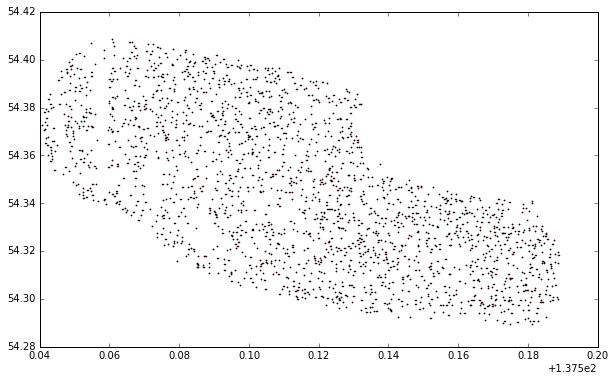

In [14]:
#I can make a 2D numberdensity binary hist to merger front or merger back, then fit contours in ds9
#Contours will automatically follow region outline. Covert .con to polygon.
cat_gq.set_index(['slice_i2','z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
rvirB=1.01207064831
rvirA=0.820350458861
#rvir = r200/1.14
r200A=rvirA*1.14
r200B=rvirB*1.14
zCB= 1.1024208 #mean redshift B
zCA= 1.1003972 #mean redshift A
sigmaA, sigmaA_err=681.2,170.1
sigmaB, sigmaB_err=840.4,244.0
#CENTROIDS
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
M200A, M200B = 2.91546371993e+14,5.47446715836e+14 #5.47446715836, 2.91546371993
#def angendpt(ra1,dec1,d_arcmin,pa):
#tools.angendpt(raA,decA,rvir*Mpc2)
#tools.angdist(a,b,raA,decA)*60*60
#Make points plot in hist dense, use cat_gq
#I don't remember if I did it normed or not but prolly doesn't matter in this case
for bina,binb in zip(dic['merger back'],dic['merger front']): 
    ra=cat_gq.loc[bina].ra
    dec=cat_gq.loc[bina].dec
    #py.plot(ra,dec,'bo',ms=1)
    cat=pd.DataFrame({'alpha':ra,'delta':dec})
    #cat=pd.DataFrame({'RA':ra2,'DEC':dec2,'weight':weight2})
    ##numberdensity(cat,2000, 'PGpz2000_merger_back') #Not totally sure this makes a difference
    #for bina,binb in zip(dic['merger back'],dic['merger front']): 
    #ra=cat_gq.loc[binb].ra
    ra=pd.concat([cat_gq.loc[binb].ra,cat_gq.loc[binb].ra+0.0001])
    dec=pd.concat([cat_gq.loc[binb].dec,cat_gq.loc[binb].dec])
    py.plot(ra,dec,'ro',ms=1)
    #cat=pd.DataFrame({'alpha':ra,'delta':dec})
    #cat.to_csv('mergerfront_rev2.tab',sep='\t',header=False, index=False)
    cat=pd.DataFrame({'alpha':ra,'delta':dec})
    ##numberdensity(cat,1000, 'PGpz1000_merger_front')
#numberdensity(cat2,1000, 'MBsz1000_weight_norm_rev2_cat2',weights=True)
#numberdensity(cat2,1000, 'MBsz1000_weight_norm_rev2_cat2',weights=True)

In [15]:
#This cell makes coadds
#filename=filepath+'/cats_groupby/'+folder+'/cat_all_PG_slice_'+ folder+'.tab'
#cat_gq=pd.read_csv(filename,sep='\t')
folder='Rvir_radialg4'
targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'
cat_gq.set_index(['z_group','q_group','slice'],drop=False,inplace=True)
print 'Removing T08_LRIS JUST from co-add cat:',cat_gq[cat_gq.maskname=='T08_LRIS'].xs(['cz','high'],level=['z_group','q_group']).id_spec.count() ,'For co-add keep id_phot=-1:',cat_gq[cat_gq.id_phot==-1].xs(['cz','high'],level=['z_group','q_group']).id_spec.count(),'unless T08_LRIS:',cat_gq[(cat_gq.id_phot==-1)&(cat_gq.maskname=='T08_LRIS')].xs(['cz','high'],level=['z_group','q_group']).id_spec.count()
print 'Removing AGN at our cluster objects with a high quality spectrum based on DEIMOS comments'
print cat_gq[(cat_gq.comments.str.contains('AGN',na=False))|(cat_gq.maskname=='T08_LRIS')].xs(['cz','high'],level=['z_group','q_group'])[['id_spec','comments','q','z_group','maskname','slice','LFC_RA', 'LFC_DEC','Z']]
print '\nAGN, T08 within mag range <=23.25'
print cat_gq[(cat_gq.Z<=23.25)&((cat_gq.comments.str.contains('AGN',na=False))|(cat_gq.maskname=='T08_LRIS'))].xs(['cz','high'],level=['z_group','q_group'])[['id_spec','comments','q','z_group','maskname','slice','LFC_RA', 'LFC_DEC']]
print '\nAGN, T08 outside mag range >23.25 (in which case DO NOT add to plot)'
print cat_gq[(cat_gq.Z>23.25)&((cat_gq.comments.str.contains('AGN',na=False))|(cat_gq.maskname=='T08_LRIS'))].xs(['cz','high'],level=['z_group','q_group'])[['id_spec','comments','q','z_group','maskname','slice','LFC_RA', 'LFC_DEC']]
cat_coadd=cat_gq[~((cat_gq.comments.str.contains('AGN',na=False))|(cat_gq.maskname=='T08_LRIS'))].xs(['cz','high'],level=['z_group','q_group'])
cat_coadd['id_spec2']=cat_coadd.id_spec.str.replace(r'0910[A-Z]+_[0-9]+s','0')
cat_coadd['id_spec2'].fillna(cat_coadd.id_spec,inplace=True)
cat_coadd['id_spec2']=cat_coadd.id_spec2.astype('int64')
cat_coadd[cat_coadd.id_spec2.notnull()]['id_spec2']=cat_coadd[cat_coadd.id_spec2.notnull()]['id_spec2'].astype('int64')
print 'with pz, with specz',cat_coadd.id.count(),cat_coadd.id_spec.count()
cat_coadd.set_index(['id','z_group','q_group'],drop=False,inplace=True)
print 'Mask and AGN cut removed:',cat_coadd.xs(['cz','high'],level=['z_group','q_group']).groupby('slice').size()-cat_gq.xs(['cz','high'],level=['z_group','q_group']).groupby('slice').size()
print 'Making Mag cut in coadd cat at 23.25'#, then 0.9,22.5' #Do second round with 22.5
cat_coadd=cat_coadd[cat_coadd.Z<=23.25]
#cat_coadd=cat_coadd[(cat_coadd.IZ<=0.9)&(cat_coadd.Z<=22.5)] #temporary color cut
print 'Addition of mag and AGN cut removed:',cat_coadd.xs(['cz','high'],level=['z_group','q_group']).groupby('slice').size()-cat_gq.xs(['cz','high'],level=['z_group','q_group']).groupby('slice').size()
print 'Outputting to groupby for coadds based on new slice schema, can use numbers and/or labels'
print '\nZ band MMCG North',cat_gq[cat_gq.id_spec==6451].Z
print cat_coadd.groupby(['slice','slice_i2']).size()
#reload(t)
grouped_xbins_coadd=cat_coadd.groupby('slice_i2')
for a,b in grouped_xbins_coadd: 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i.unique()
onenull=(cat_coadd.R.isnull()|cat_coadd.I.isnull()|cat_coadd.Z.isnull())
print 'With at least one null (cannot use in CMD):'
print cat_coadd[onenull].groupby(['q_group','z_group','slice']).size()
cat_coadd.set_index(['slice_i2'],drop=False,inplace=True)
#Ft1_avg,Ft4_avg = cat_coadd['F_tAB'].loc[bina].mean(),cat_coadd['F_tAB'].loc[binb].mean()
#delFt_avg = Ft1_avg - Ft4_avg #Avg force merger back 1, merger front 4...should be negative
#print delFt_avg, bina,Ft1_avg, binb,Ft4_avg,Ft1_avg/Ft4_avg,'back/front should be < 1 for force on front galaxies greater' 
#print Ft4_avg/Ft1_avg,'time greater <tidal force> on merger front than back galaxies'


Removing T08_LRIS JUST from co-add cat: 2 For co-add keep id_phot=-1: 3 unless T08_LRIS: 1
Removing AGN at our cluster objects with a high quality spectrum based on DEIMOS comments
            id_spec                             comments    q z_group  \
slice                                                                   
core A         5738                                  NaN  3.0      cz   
merger back   12538  wide_OII!_wide_NeIII!_wide_NeV,_AGN  4.0      cz   
infall A       5808                                  NaN  3.0      cz   

             maskname        slice      LFC_RA    LFC_DEC       Z  
slice                                                              
core A       T08_LRIS       core A  137.687119  54.367347  21.646  
merger back    0910MB  merger back  137.575667  54.424990  22.262  
infall A     T08_LRIS     infall A  137.701479  54.374908     NaN  

AGN, T08 within mag range <=23.25
            id_spec                             comments    q z_group  \
slice

In [16]:
#Force calcs evaluated on co-add objets only
cat_coadd.set_index(['slice_i2'],drop=False,inplace=True)
#Change for cat_coadd, could move down to where do EWOII SFR stuff, make sure run F_functs above  
#Do this for only coadd galaxies once assign bins
for bina,binb in zip(dic['merger back'],dic['merger front']): 
    Ft1_avg,Ft4_avg = cat_coadd['F_tAB'].loc[bina].mean(),cat_coadd['F_tAB'].loc[binb].mean()
    delFt_avg = Ft1_avg - Ft4_avg #Avg force merger back 1, merger front 4...should be negative
    print delFt_avg, bina,Ft1_avg, binb,Ft4_avg,Ft1_avg/Ft4_avg,'back/front should be < 1 for force on front galaxies greater' 
    print Ft4_avg/Ft1_avg,'time greater <tidal force> on merger front than back galaxies'


-2.80912654461e+29 1 4.22476323499e+29 4 7.0338897796e+29 0.600629718032 back/front should be < 1 for force on front galaxies greater
1.66491928384 time greater <tidal force> on merger front than back galaxies


In [17]:
print 'No mag cut yet. Color-Mag histograms will show how these are distributed'
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
print 'Num photometric objects in region, pz is in photoz range\n',cat_gq.groupby(['slice','z_group_pz']).size()
print 'Num high quality confirmed LSS members with photozs cluster photoz range (pz)\n',cat_gq[(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')].groupby(['slice','z_group_pz']).size()
blah=((cat_gq[(cat_gq.Z<=23.25)&(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')&(cat_gq.z_group_pz=='pz')].groupby(['slice','z_group_pz']).size().reset_index()[0])/(cat_gq[(cat_gq.Z<=23.25)&(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')&(cat_gq.z_group_pz=='nz')].groupby(['slice','z_group_pz']).size().reset_index()[0]+cat_gq[(cat_gq.Z<=23.25)&(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')&(cat_gq.z_group_pz=='pz')].groupby(['slice','z_group_pz']).size().reset_index()[0]))
index0=cat_gq[(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')&(cat_gq.z_group_pz=='nz')].groupby(['slice']).size().index
blah.index=index0
print 'Percent of confirmed LSS objects with photozs in cluster photoz range ((EDIT:cat_gq.Z<=23.25)&) (Should be >68%)\n',blah*100
print 'Percent of total photoz range objects confirmed to be in LSS (I should subtract the number of *pz* confirmed out to gauge how much of the population we have, but the values listed below indicate very few pz were nz)\n',(cat_gq[(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')].groupby(['slice','z_group_pz']).size()/cat_gq.groupby(['slice','z_group_pz']).size() )*100.
print 'Percent of total photoz range objects confirmed to be in LSS Z<23.25\n',(cat_gq[(cat_gq.Z<=23.25)&(cat_gq.q_group=='high')&(cat_gq.z_group=='cz')&(cat_gq.z_group_pz=='pz')].groupby(['slice','z_group_pz']).size()/cat_gq[(cat_gq.Z<23.25)&(cat_gq.z_group_pz=='pz')].groupby(['slice','z_group_pz']).size() )*100.
print 'Percent of total photoz range objects confirmed to be outside LSS (Should be small: failure type II)\n',cat_gq[(cat_gq.q_group=='high')&(cat_gq.z_group=='nz')].groupby(['slice','z_group_pz']).size()/cat_gq.groupby(['slice','z_group_pz']).size()


No mag cut yet. Color-Mag histograms will show how these are distributed
Num photometric objects in region, pz is in photoz range
slice         z_group_pz
core A        nz             129
              pz              26
core B        nz             154
              pz              33
infall A      nz             915
              pz              89
infall B      nz            1215
              pz             140
merger back   nz            7107
              pz             586
merger front  nz            1889
              pz             149
unassigned    nz            7292
              pz             496
dtype: int64
Num high quality confirmed LSS members with photozs cluster photoz range (pz)
slice         z_group_pz
core A        nz             3
              pz             5
core B        nz             3
              pz             6
infall A      nz             7
              pz             9
infall B      nz             6
              pz            12
merger back   nz   

In [18]:
#Histograms
#mpld3.enable_notebook()
#from matplotlib.ticker import NullFormatter
from matplotlib.ticker import NullFormatter

cat_gq=cat_gq[cat_gq.Z<=23.25]
py.rcParams['figure.figsize'] = (10, 7)
#Now do completeness plots based on the slices made above. Here can select and combine particular slices
#Make algorithm to select and combine slices then apply mask...then output to co-add cat or bin co-add cat this way too
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz','z_group_pz2'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...

cat_gq.IZ=cat_gq.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_gq.RZ=cat_gq.RZ.replace([np.inf, '-99',-99], np.nan)
cat_gq.RI=cat_gq.RI.replace([np.inf, '-99',-99], np.nan)

#APPLY MASK (is this before or after when coadd cat is made? Move to before if want to apply to co-adds)
cat_gq=cat_gq[cat_gq.yprime<7.025]

#Move this up and do all operations    
    #Did I remove spec galaxies without photometry?
#    print 'All ORELSE galaxies with photozs in pz range:', len( cat_all.xs([cid,'pz'],level=['z_group_pz']).Z )
    #cat_gq.loc[bins_cmd].r
#print cat_gq.loc[['3','2']].r
#print cat_all_temp.xs(['high','cz'],level=['q_group','z_group']).loc[['3','2']].R

#print cat_all_temp.xs(['high','cz'],level=['q_group','z_group']).R

#cat_all=pd.read_csv('/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cat_all_PG.tab',sep='\t')
#Now I should create a CMD for whichever slices (can add many and also combine or change grou names)
#To add two groups (and maybe output cat from here with name)
#big_df.index.names=[u'pops', u'region', u'color', u'EW'] #maybe do this with dupes
#big_df=big_df.reorder_levels([u'pops', u'EW', u'region', u'color'])
#blah=['1','2']
#for a in blah: #FOr grouby object to concat to df maybe
#    print grouped_xbins_i.get_group(str(a))
#cat_gq.loc[['1','2'],:] #select from cat with multi (or columns?), works with 
#cat_gq.loc[('1','3'),['slice','r']]
#cat_gq.rename(index={'1':'core','2':'core'},inplace=True) #rename indices-'2':'core', then select easily for composites or groupby
#xs only works if multiple multiindex, otherwise use cat_gq.loc['core']
#labels=[str(i+1) for i in arange(len(bins)-1)]
#labels=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
#labels2=[['1','13'],['2','3'],['4'],['5','6'],['7'],['8','9','10','11','12'] ]
#labels2_names=[['merger_back'],['2','3','4','5','6'],['merger_front'],['8','9','10','11','12'] ]

hqcz=['high','cz']
hqnz=['high','nz']
hqczpz=['high','cz','pz']
#lqcz=['low','cz']
#lq=['low']
level=['z_group_pz']
level2=['q_group','z_group']
level3=['q_group','z_group','z_group_pz'] #for groupby and stats
#print level3.reverse()

#Apply mask to mid-radial bins to condense to new bins with given name, maybe store as new index:
#8



#print cat_gq.loc[['3','2']].xs(hqcz,level=level2).R
#print cat_gq.loc[['3','2']].xs(['high','cz'],level=['q_group','z_group']).R

##print cat_gq.loc[labels2[0]].groupby(level3).size()
##print cat_gq.loc[:].groupby(level3).size()
'''
for group in labels:
    print group, cat_gq.loc[group].q_group.count(),cat_gq.loc[group].R.count() #3rd one excludes specz where null
    print cat_gq.loc[group].groupby(level3).size()   
Change this to be more like cat_all, pasted fro original coadd groupby output way above here
grouped_xbins_coadd = cat_coadd[['id_spec', 'maskname', 'slit', 'LFC_RA', 'LFC_DEC', 'R', 'I', 'Z', 'redshift', 'z_spec_err', 'q', 'old_id']].groupby(pd.cut(cat_coadd.xprime,bins))

'''
#bins_cmd=[str(i+1) for i in arange(len(bins3)-1)] #string labels 1-13
#This should be ok since order doesn't matter for output of each file if 7 is first
bins_cmd=[i for i in cat_gq.slice_i2.unique()] #string labels 7 to include unassigned
labels_cmd=[i for i in cat_gq.slice.unique()]
print bins_cmd,labels_cmd, targetdir
#binwMpc=[(round(abs(bins[i]-bins[i+1])*dx2Mpc,2),i+1) for i in arange(len(bins)-1)]#print '{:.2f}'.format(zip(*binwMpc)[0])

#binw,n = zip(*binwMpc)[0],zip(*binwMpc)[1] #these won't directly match up if concence bins, so add widths as well
#print bins_cmd.sort() #does this fix order so not 1, 10, 12,13,2...?
#Want to do this for unassigned too so maybe do zip instead of dic
for bin,label in zip(bins_cmd,labels_cmd):
    print bin,label
    fig, ax = py.subplots()
    cid=str(bin)
    #quit()
    #figname='CMD bin #'+cid+' '+label
    #1
    #figname='CMD (z=[1.09,1.12] Q=3,4 )'
    figname='Color Magnitude Diagram RXJ0910, z=[1.09,1.12]'
    #py.title(figname,fontsize=25)
    #stats= '\n'+str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.xs(hqcz,level=level2).Z))+' confirmed members in structure (black dots)'
    #py.title(figname+stats+stats2,fontsize=14)
    #2
    #figname='CMD of '
    #stats= str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.loc[bin].Z))+' photometric objects in bin (black dots)'
    #2b pz
    #stats2 = '\n'+str(len(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z))+r' $z_{phot}$=$z_{clust}\pm\sigma_{phot}$ photometric objects in bin (black dots)'
    #stats3='\n'+str(len(cat_gq.xs(hqnz,level=level2).loc[bin].Z)+len(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z))+r' high Q non-$z_{clust}$ objects in bin (green x) '+'\n'+str(len(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z))+' low Q objects in bin (orange x)'
    #py.title(figname+stats+stats2+stats3,fontsize=20)

    #If we extend the range slightly, do we get more bright blue galaxies in merger front?
    #Should have blank squares, if there is a filamentary structure
    #This range is larger than the . We know some are added based on proposal plot but those didn't have mag cuts and may have been out of range
    #py.plot(cat_gq[(cat_gq.z_spec<=1.14)&(cat_gq.z_spec>=1.08)].xs(['high'],level=['q_group']).loc[bin].Z,cat_gq[(cat_gq.z_spec<=1.14)&(cat_gq.z_spec>=1.08)].xs(['high'],level=['q_group']).loc[bin].IZ,'rs',mec='r',mfc='w',mew=2,ms=10,alpha=1)
    
    #Could Also do added pz objects on this plot to be efficient, so make r. for new range pz objects
    #Ok this might be easier on the other plot, or useful here cause will see they are in cz pz
    
    #2sig I was lazy and put this on fig 1 cz plot so this is kinda messy but gets the job done
    #py.plot(cat_gq[cat_gq.pzcdf>=0.23].loc[bin].Z,cat_gq[cat_gq.pzcdf>=0.23].loc[bin].IZ,'ro',ms=5)

    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].IZ,'rd',ms=7)
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].IZ,'wd',ms=8,mec='w')
    #py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].Z,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'wx',mec='w',mfc='w',mew=4,ms=7)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'w',mec='w',mfc='w',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'wx',mec='w',mfc='w',mew=4,ms=7)

    
    #1&2
    #All spec confirmed hq, cz objects in each bin/slice
    #print '# photometric objects: MB',len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)
    #print '# photometric objects: MF',len(cat_gq.xs(hqcz,level=level2).loc['4'].Z)

    py.plot(cat_gq.xs(hqcz,level=level2).loc[bin].Z,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,'bs',mec='b',mfc='w',mew=2,ms=10,alpha=1)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'ms',mec='m',mfc='w',mew=2,ms=10,alpha=1)
    #DUAL only
    py.plot(cat_gq.xs(hqcz,level=level2).loc['4'].Z,cat_gq.xs(hqcz,level=level2).loc['4'].IZ,'rs',mec='r',mfc='w',mew=2,ms=10,alpha=1)
    #MEDIANS from below for MF and MB
    #1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
    #  [0.12917896207402116, 0.16430580776895826]
    #I-Z color merger back (red), front (blue): [0.057266507521358118, 0.076927294971369062]
    #Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]    
    #py.plot([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],'ks',ms=13,mfc='None',mew=2,alpha=1.0) #should I also do median? Median is better if there are lot of outliers
    py.plot([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median()],'bD',ms=16,mfc='None',mew=2,alpha=1.0,mec='b') #should I also do median? Median is better if there are lot of outliers
    py.plot([cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],'rD',ms=16,mfc='None',mew=2,alpha=1.0,mec='r') #should I also do median? Median is better if there are lot of outliers
    #Relate uncertainty on the mean to median with 1.253 from Hathi 2016
    
    #py.errorbar([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='r',elinewidth=2)   
    py.errorbar([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='b', elinewidth=2)   
    py.errorbar([cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='r', elinewidth=2)   

    #NOTE CHANGE THESE TO ADD .IZ if not doing lmass
    MF=pd.concat([cat_gq.xs(hqcz,level=level2).loc['4'].Z,cat_gq.xs(hqcz,level=level2).loc['4'].IZ,cat_gq.xs(hqcz,level=level2).loc['4'].lmass],axis=1)
    MB=pd.concat([cat_gq.xs(hqcz,level=level2).loc[bin].Z,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,cat_gq.xs(hqcz,level=level2).loc[bin].lmass],axis=1)
    
    #Old slice 7 from very first merger front binning
    #py.plot(cat_gq[cat_gq.slice_i=='7'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice_i=='7'].xs(['high','cz'],level=['q_group','z_group']).IZ,'rs',mec='r',mfc='w',mew=3,ms=10,alpha=1)
    #Core out to radius 3.5*Rvir
    #py.plot(cat_gq[cat_gq.slice_i34=='merger front 3p5'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice_i34=='merger front 3p5'].xs(['high','cz'],level=['q_group','z_group']).IZ,'rx',mec='r',mfc='w',mew=2,ms=10,alpha=0.9)

    #py.plot(cat_gq[cat_gq.slice_i34=='merger front 3p5'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice_i34=='merger front 3p5'].xs(['high','cz'],level=['q_group','z_group']).IZ,'gx',mec='g',mfc='w',mew=2,ms=10,alpha=0.9)
    #Only items from new 4Rvir merger front, will show up on all plots
    #py.plot(cat_gq[cat_gq.slice=='merger front'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice=='merger front'].xs(['high','cz'],level=['q_group','z_group']).IZ,'rs',mec='r',mfc='None',mew=2,ms=10,alpha=1)
    #py.plot(cat_gq[cat_gq.slice=='unassigned'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice=='unassigned'].xs(['high','cz'],level=['q_group','z_group']).IZ,'bs',mec='b',mfc='None',mew=2,ms=10,alpha=1)

    #Between radii 3.5-4Rvir, this will cover all 4   
    #py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).Z,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).IZ,'rs',mec='r',mfc='w',mew=3,ms=10,alpha=1)
    #py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).loc[bin].Z,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).loc[bin].IZ,'bs',mec='b',mfc='w',mew=3,ms=10,alpha=1)

    #'rx',mec='r',mfc='w',mew=2,ms=10,alpha=

    
    #2
    #All spec confirmed hq, nz objects in each bin/slice, including stars and LRIS (magenta)
    #py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].Z,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)

    
    
    #2
    #All targeted but lq spec objects in each bin/slice (any photoz value pz+nz)
    #py.plot(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z,cat_gq.xs(['low'],level=['q_group']).loc[bin].IZ,color='orange',marker='x',mec='darkorange',linestyle='None',mfc='orange',mew=4,ms=7,alpha=1)
    #py.plot(cat_gq.xs(lqcz,level=level2).loc[bin].Z,cat_gq.xs(lqcz,level=level2).loc[bin].IZ,'ox',mec='x',mfc='o',mew=2,ms=10,alpha=1)
    #Should I do untargeted/lowq with photz in pz range? Or lowq with photoz in pz range?
    
    #All photometric objects in LSS FOV with photoz in pz range
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).Z,cat_gq.xs(['pz'],level=['z_group_pz']).IZ,'ko',ms=1,alpha=0.5)

    #2a
    #ALL photometric objects in each bin/slice, no photoz limit use=1 (doesn't include specz without pz match)
    #py.plot(cat_gq.loc[bin].Z,cat_gq.loc[bin].IZ,'ko',ms=0.8)

    #2b
    #All photoemtric objects in each bin slice with photoz in pz/nz range (note many had nz so maybe include all)
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].IZ,'ro',ms=3)
    #py.plot(cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=1,alpha=0.9)
    '''
    print '\n1sig,2sig pz, low, star, nan quality, all Z',len(cat_gq[(cat_gq.q_group=='low')|(cat_gq.q_group==np.nan)].xs(['pz'],level=['z_group_pz2']).loc[bin].Z),len(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc[bin].Z)    
    print len(cat_gq[(cat_gq.q_group!='high')].xs(['pz'],level=['z_group_pz2']).loc[bin].Z)
    print cat_gq.groupby('q_group').size()
    n,bins, patches =py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc[bin].Z)
    #print sum(n),sum(n[n<22.5])
    print n,'missing from 2sig range'
    n,bins, patches =py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.Z<22.5)].xs(['pz'],level=['z_group_pz2']).loc[bin].Z)
    print n,sum(n), 'missing from 2sig range Z<22.5, bright blue'
    n,bins, patches =py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.Z<22.5)].xs(['pz'],level=['z_group_pz']).loc[bin].Z)
    print n,sum(n),'missing from 1sig range, bright blue'
    #print n,bins,patches
    py.close()
    '''
    '''
    MB2sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc[bin].IZ],axis=1)
    MB1sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc[bin].IZ],axis=1)
    MF2sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc['4'].IZ],axis=1)
    MF1sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc['4'].IZ],axis=1)
    #MBpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].IZ],axis=1)
    #MFpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].IZ],axis=1)
    MBpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].IZ],axis=1)
    MFpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].IZ],axis=1)
    '''
    '''
    MB2sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc[bin].lmass],axis=1)
    MB1sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc[bin].lmass],axis=1)
    MF2sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz2']).loc['4'].lmass],axis=1)
    MF1sig=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')].xs(['pz'],level=['z_group_pz']).loc['4'].lmass],axis=1)
    #MBpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].IZ],axis=1)
    #MFpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].IZ],axis=1)
    MBpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc[bin].lmass],axis=1)
    MFpz23=pd.concat([cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].Z,cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group!='star')&(cat_gq.pzcdf>=0.23)].loc['4'].lmass],axis=1)

    '''
    '''
    #print '\n',bin, 'MB, MF: ',len(MBpz23),len(MFpz23)
    #print 'MERGER FRONT STATS',MF.info(),MF1sig.info(),MF2sig.info(),'\nconcat',pd.concat([MF,MF2sig]).info()
    #print 'MERGER BACK STATS',MB.info(),MB1sig.info(),MB2sig.info(),'\nconcat',pd.concat([MB,MB2sig]).info()

    print 'MF MB hQspecz KS test: ',ks_2samp(pd.concat([MF],ignore_index=True).Z, pd.concat([MB],ignore_index=True).Z )
    print 'MF MB hQspecz+1sigpz KS test: ',ks_2samp(pd.concat([MF,MF1sig],ignore_index=True).Z, pd.concat([MB,MB1sig],ignore_index=True).Z )
    print 'MF MB hQspecz+2sigpz KS test:',ks_2samp(pd.concat([MF,MF2sig],ignore_index=True).Z,  pd.concat([MB,MB2sig],ignore_index=True).Z )
    print 'MF MB hQspecz+p(z)>0.23 KS test: ',ks_2samp(pd.concat([MF,MFpz23],ignore_index=True).Z, pd.concat([MB,MBpz23],ignore_index=True).Z )
    
    print '\nColor I-Z'
    print 'MF MB hQspecz KS test: ',ks_2samp(pd.concat([MF],ignore_index=True).IZ, pd.concat([MB],ignore_index=True).IZ )
    print 'MF MB hQspecz+1sigpz KS test: ',ks_2samp(pd.concat([MF,MF1sig],ignore_index=True).IZ, pd.concat([MB,MB1sig],ignore_index=True).IZ )
    print 'MF MB hQspecz+2sigpz KS test:',ks_2samp(pd.concat([MF,MF2sig],ignore_index=True).IZ,  pd.concat([MB,MB2sig],ignore_index=True).IZ )
    print 'MF MB hQspecz+p(z)>0.23 KS test: ',ks_2samp(pd.concat([MF,MFpz23],ignore_index=True).IZ, pd.concat([MB,MBpz23],ignore_index=True).IZ )
    '''
    '''
    print '\nStellar Mass'
    print 'MF MB hQspecz KS test LMASS: ',ks_2samp(pd.concat([MF],ignore_index=True).lmass, pd.concat([MB],ignore_index=True).lmass )
    print 'MF MB hQspecz+1sigpz KS test: ',ks_2samp(pd.concat([MF,MF1sig],ignore_index=True).lmass, pd.concat([MB,MB1sig],ignore_index=True).lmass )
    print 'MF MB hQspecz+2sigpz KS test:',ks_2samp(pd.concat([MF,MF2sig],ignore_index=True).lmass,  pd.concat([MB,MB2sig],ignore_index=True).lmass )
    print 'MF MB hQspecz+p(z)>0.23 KS test: ',ks_2samp(pd.concat([MF,MFpz23],ignore_index=True).lmass, pd.concat([MB,MBpz23],ignore_index=True).lmass )
    print '\n check stellar mass values:'
    #print MF1sig.lmass, MB1sig.lmass
    
    '''
    
    #'''
    
    #1
    #All spec confirmed hq, cz objects in LSS 
    #If you comment this out, then change the x-axis range to allow for all photoz objects 21, 27
    ax.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    #points=ax.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    #1 ext 2 sig
    #Now see what is added when extend range from pz to 2pz. Note some of these may have been confirmed out as green crosses
    
    
    #histogram stuff
    xF=MF.Z
    xB=MB.Z
    yF=MF.IZ
    yB=MB.IZ
    '''
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left+width+0.02
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    # Calculate number of bins based on binsize for both x and y
    min_x_data, max_x_data = np.min(x), np.max(x)
    binsize = 0.1
    num_x_bins = np.floor((max_x_data - min_x_data) / binsize)
    min_y_data, max_y_data = np.min(y), np.max(y)
    binsize = 0.1
    num_y_bins = np.floor((max_y_data - min_y_data) / binsize)
    fig = py.figure(221, figsize=(11.3, 7.3))
    axScatter = fig.add_subplot(223, position=rect_scatter)
    axScatter.set_xlim(20.5,23.26)
    axScatter.set_ylim(0.0,1.4)
    axHistX = fig.add_subplot(221, position=rect_histx)
    axHistX.set_ylim(0,30)
    axHistX.set_xlim(19.5,23.5)
    axHistY = fig.add_subplot(224, position=rect_histy)
    axHistY.set_ylim(0.1,1.6)
    # Remove labels from histogram edges touching scatter plot
    axHistX.xaxis.set_major_formatter(nullfmt)
    axHistY.yaxis.set_major_formatter(nullfmt)
    axScatter.scatter(x, y, marker='*', color = 'darkblue', edgecolor='none', s=90, alpha=0.7)
    # Draw x-axis histogram
    #axHistX.hist(x, num_x_bins, ec='green', fc='none', histtype='step')
    axHistX.hist(x,  fc='green', histtype='stepfilled',alpha=0.5,orientation='vertical')
    # Draw y-axis histogram
    axHistY.hist(y,  fc='green', histtype='stepfilled', alpha=0.5, orientation='horizontal')
    '''


    filename='CMD_'+cid+'_'+label+'_dual'
    py.xticks([21.0,21.5,22.0,22.5,23.0],fontsize=50)
    py.yticks([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=50)

    py.ylim((0.0,1.4))
    ax.set_ylim((0.0,1.4))
    #1
    #py.xlim((20.5,24.5))
    py.xlim((20.5,23.26))
    #2
    #py.xlim((20,27))
    #py.xlim((20,25))

    xmin, xmax = py.xlim()
    ymin, ymax = py.ylim()
    #py.text(xmax-1.6, ymax-0.29,cid+' '+label, color='k', fontsize='25')
    py.xlabel(r'$Z^{+}$',fontsize=25)
    py.ylabel(r'$I^{+}-Z^{+}$',fontsize=25)
    #py.tight_layout()
    py.tick_params(axis='both', which='major', labelsize=15)
    
    '''
    #MPLD3 not sure what happens to null values
    labelsp = []
    for i in range(len(cat_gq.xs(hqcz,level=level2))):
        #    label = df.ix[[i], :].T
        labelp=cat_gq.xs(hqcz,level=level2).ix[[i], ['slice','slice_i','Z','ra','dec','z_group','z_group_pz','q_group']].T
        labelp.columns = ['{0}'.format(cat_gq.xs(hqcz,level=level2).id_phot[i])]
        # .to_html() is unicode; so make leading 'u' go away with str()
        labelsp.append(str(labelp.to_html()))    
    tooltip = plugins.PointHTMLTooltip(points[0], labelsp,voffset=10, hoffset=10, css=css)
    mpld3.plugins.connect(fig, tooltip)
    #mpld3.display()
    mpld3.save_html(fig, targetdir+'CMD_PG_'+label+'.html')
    '''
    
    #%pdb
    #pdb.set_trace()
    #py.savefig(targetdir+'plots/'+filename,bbox_inches='tight')

    #py.savefig(filename,bbox_inches='tight')
    #py.savefig(filename)

    py.close()
    
    
    #CSMD
    filename='CSMD_'+cid+'_'+label+'_dual'

    #figname='CMD bin #'+cid+' '+label
    #1
    figname='Color Stellar Mass Diagram RXJ0910, z=[1.09,1.12]'
    py.title(figname,fontsize=24)

    #stats= '\n'+str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.xs(hqcz,level=level2).Z))+' confirmed members in structure (black dots)'
    #py.title(figname+stats+stats2,fontsize=14)
    #2
    #figname='CSMD of '
    #stats= str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.loc[bin].Z))+' photometric objects in bin (black dots)'
    #2b
    #stats2 = '\n'+str(len(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z))+r' $z_{phot}$=$z_{clust}\pm\sigma_{phot}$ photometric objects in bin (black dots)'
    #stats3='\n'+str(len(cat_gq.xs(hqnz,level=level2).loc[bin].Z)+len(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z))+r' high Q non-$z_{clust}$ objects in bin (green x) '+'\n'+str(len(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z))+' low Q objects in bin (orange x)'
    #print '% spec-z confirmed members with photo-z in expanded photo-z range sig~0.084:'
    #py.title(figname+stats+stats2+stats3,fontsize=16)

    #1&2
    #All spec confirmed hq, cz objects in each bin/slice
    py.plot(cat_gq.xs(hqcz,level=level2).loc[bin].lmass,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,'bs',mec='b',mfc='w',mew=2,ms=10,alpha=1,label='Merger Back')
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].lmass,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'ms',mec='m',mfc='w',mew=2,ms=10,alpha=1)
    #DUAL ONLY
    py.plot(cat_gq.xs(hqcz,level=level2).loc['4'].lmass,cat_gq.xs(hqcz,level=level2).loc['4'].IZ,'rs',mec='r',mfc='w',mew=2,ms=10,alpha=1,label='Merger Front')

    #2
    #All spec confirmed hq, nz objects in each bin/slice, including stars and LRIS (magenta)
    #py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].lmass,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].lmass,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].lmass,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)

    #2
    #All targeted but lq spec objects in each bin/slice (any photoz value pz+nz)
    #py.plot(cat_gq.xs(['low'],level=['q_group']).loc[bin].lmass,cat_gq.xs(['low'],level=['q_group']).loc[bin].IZ,color='orange',marker='x',mec='darkorange',linestyle='None',mfc='orange',mew=4,ms=7,alpha=1)
    #py.plot(cat_gq.xs(lqcz,level=level2).loc[bin].lmass,cat_gq.xs(lqcz,level=level2).loc[bin].IZ,'ox',mec='x',mfc='o',mew=2,ms=10,alpha=1)
    #Should I do untargeted/lowq with photz in pz range? Or lowq with photoz in pz range?
    
    #All photometric objects in LSS FOV with photoz in pz range
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).lmass,cat_gq.xs(['pz'],level=['z_group_pz']).IZ,'ko',ms=1,alpha=0.5)

    #2
    #ALL photometric objects in each bin/slice, no photoz limit use=1 (doesn't include specz without pz match)
    #py.plot(cat_gq.loc[bin].lmass,cat_gq.loc[bin].IZ,'ko',ms=0.8)

    #2b
    #All photoemtric objects in each bin slice with photoz in pz/nz range (note many had nz so maybe include all)

    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].lmass,cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].IZ,'ko',ms=2)
    #py.plot(cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].lmass,cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=1,alpha=0.9)

    #1
    #All spec confirmed hq, cz objects in LSS 
    #If you comment this out, then change the x-axis range to allow for all photoz objects 21, 27
    py.plot(cat_gq.xs(hqcz,level=level2).lmass,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1,label='All Objects')

    #filename='CSMD_'+cid
    py.ylim((0.0,1.4))
    #1
    #py.xlim((12,9))
    #2
    py.xlim((12,9))
    #py.xlim((12,7.5))

    xmin, xmax = py.xlim()
    ymin, ymax = py.ylim()
    #py.text(xmax+1.2, ymax-0.3,cid+' '+label, color='k', fontsize='25')
    py.xlabel(r'$log(M_{*} M_{\odot}^{-1})$', fontsize=21)
    py.ylabel(r'$I-Z$',fontsize=21)
    py.tick_params(axis='both', which='major', labelsize=15)
    py.legend()
    #py.tight_layout()
    #py.savefig(targetdir+'plots/'+filename,bbox_inches='tight')
    py.close()
    #print cat_all.loc[bin].groupby(['q_group','z_group']).size()

#CMD/CSMD



['1', '2', '3', '4', '5', '6', '7'] ['merger back', 'infall B', 'core B', 'merger front', 'infall A', 'core A', 'unassigned'] /Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/Rvir_radialg4/
1 merger back
2 infall B
3 core B
4 merger front
5 infall A
6 core A
7 unassigned


22.066
21.834
10.7604166667
10.6058823529


(array([ 1.,  1.,  1.,  0.,  0.,  2.,  2.,  3.,  1.,  2.,  3.,  0.,  0.,
         0.,  2.,  1.,  2.,  0.,  0.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
         3.,  2.,  1.,  2.,  2.,  2.,  5.,  1.,  1.,  2.,  1.,  0.,  2.,
         0.,  1.,  2.,  4.,  0.,  5.,  6.,  3.,  2.,  3.,  4.]),
 array([ 19.335  ,  19.41262,  19.49024,  19.56786,  19.64548,  19.7231 ,
         19.80072,  19.87834,  19.95596,  20.03358,  20.1112 ,  20.18882,
         20.26644,  20.34406,  20.42168,  20.4993 ,  20.57692,  20.65454,
         20.73216,  20.80978,  20.8874 ,  20.96502,  21.04264,  21.12026,
         21.19788,  21.2755 ,  21.35312,  21.43074,  21.50836,  21.58598,
         21.6636 ,  21.74122,  21.81884,  21.89646,  21.97408,  22.0517 ,
         22.12932,  22.20694,  22.28456,  22.36218,  22.4398 ,  22.51742,
         22.59504,  22.67266,  22.75028,  22.8279 ,  22.90552,  22.98314,
         23.06076,  23.13838,  23.216  ]),
 <a list of 50 Patch objects>)

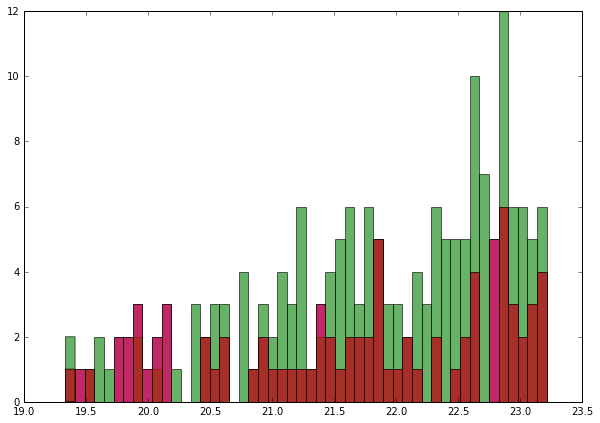

In [19]:
#Look at means and medians
#%pylab inline
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz','z_group_pz2'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
print cat_gq.xs(['nz','high'],level=['z_group','q_group']).loc['1'].Z.median()
print cat_gq.xs(['nz','high'],level=['z_group','q_group']).loc['4'].Z.median()
print cat_gq.xs(['cz','high'],level=['z_group','q_group']).loc['1'].lmass.mean()
print cat_gq.xs(['cz','high'],level=['z_group','q_group']).loc['4'].lmass.mean()
n, binss, patches=py.hist(cat_gq.xs(['nz','high'],level=['z_group','q_group']).loc['4'].Z,bins=50,alpha=.6)
py.hist(cat_gq.xs(['nz','high'],level=['z_group','q_group']).loc['1'].Z,bins=binss,alpha=.6)
py.hist(cat_gq.xs(['nz','high'],level=['z_group','q_group']).loc['4'].Z,bins=binss,alpha=.6)


In [20]:
#Making Scatter CMD/CSMDs with XY histograms
#mpld3.enable_notebook()
cat_gq=cat_gq[cat_gq.Z<=23.25]
from matplotlib.ticker import NullFormatter

#py.rcParams['figure.figsize'] = (10, 7)
#Now do completeness plots based on the slices made above. Here can select and combine particular slices
#Make algorithm to select and combine slices then apply mask...then output to co-add cat or bin co-add cat this way too
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz','z_group_pz2'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
hqcz=['high','cz']
hqnz=['high','nz']
hqczpz=['high','cz','pz']
#lqcz=['low','cz']
#lq=['low']
level=['z_group_pz']
level2=['q_group','z_group']
level3=['q_group','z_group','z_group_pz'] #for groupby and stats
#print level3.reverse()

#bins_cmd=[str(i+1) for i in arange(len(bins3)-1)] #string labels 1-13
#This should be ok since order doesn't matter for output of each file if 7 is first
bins_cmd=[i for i in cat_gq.slice_i2.unique()] #string labels 7 to include unassigned
labels_cmd=[i for i in cat_gq.slice.unique()]
print bins_cmd,labels_cmd, targetdir
#binwMpc=[(round(abs(bins[i]-bins[i+1])*dx2Mpc,2),i+1) for i in arange(len(bins)-1)]#print '{:.2f}'.format(zip(*binwMpc)[0])

#binw,n = zip(*binwMpc)[0],zip(*binwMpc)[1] #these won't directly match up if concence bins, so add widths as well
#print bins_cmd.sort() #does this fix order so not 1, 10, 12,13,2...?
#Want to do this for unassigned too so maybe do zip instead of dic
#py.close()

for bin,label in zip(bins_cmd,labels_cmd):
    print bin,label
    
    ##fig, ax = py.subplots()
    cid=str(bin)
    '''
    #1
    #stats= '\n'+str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.xs(hqcz,level=level2).Z))+' confirmed members in structure (black dots)'
    #py.title(figname+stats+stats2,fontsize=14)
    #2
    #figname='CMD of '
    #stats= str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.loc[bin].Z))+' photometric objects in bin (black dots)'
    #2b pz
    #stats2 = '\n'+str(len(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z))+r' $z_{phot}$=$z_{clust}\pm\sigma_{phot}$ photometric objects in bin (black dots)'
    #stats3='\n'+str(len(cat_gq.xs(hqnz,level=level2).loc[bin].Z)+len(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z))+r' high Q non-$z_{clust}$ objects in bin (green x) '+'\n'+str(len(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z))+' low Q objects in bin (orange x)'
    #py.title(figname+stats+stats2+stats3,fontsize=20)

    #If we extend the range slightly, do we get more bright blue galaxies in merger front?
    #Should have blank squares, if there is a filamentary structure
    #This range is larger than the . We know some are added based on proposal plot but those didn't have mag cuts and may have been out of range
    #py.plot(cat_gq[(cat_gq.z_spec<=1.14)&(cat_gq.z_spec>=1.08)].xs(['high'],level=['q_group']).loc[bin].Z,cat_gq[(cat_gq.z_spec<=1.14)&(cat_gq.z_spec>=1.08)].xs(['high'],level=['q_group']).loc[bin].IZ,'rs',mec='r',mfc='w',mew=2,ms=10,alpha=1)
    
    #Could Also do added pz objects on this plot to be efficient, so make r. for new range pz objects
    #Ok this might be easier on the other plot, or useful here cause will see they are in cz pz
    
    #2sig I was lazy and put this on fig 1 cz plot so this is kinda messy but gets the job done
    #py.plot(cat_gq[cat_gq.pzcdf>=0.23].loc[bin].Z,cat_gq[cat_gq.pzcdf>=0.23].loc[bin].IZ,'ro',ms=5)

    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].IZ,'rd',ms=7)
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].IZ,'wd',ms=8,mec='w')
    #py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].Z,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'wx',mec='w',mfc='w',mew=4,ms=7)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'w',mec='w',mfc='w',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'wx',mec='w',mfc='w',mew=4,ms=7)

    
    #1&2
    #All spec confirmed hq, cz objects in each bin/slice
    #print '# photometric objects: MB',len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)
    #print '# photometric objects: MF',len(cat_gq.xs(hqcz,level=level2).loc['4'].Z)

    py.plot(cat_gq.xs(hqcz,level=level2).loc[bin].Z,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,'bs',mec='b',mfc='w',mew=2,ms=10,alpha=1)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'ms',mec='m',mfc='w',mew=2,ms=10,alpha=1)
    #DUAL only
    py.plot(cat_gq.xs(hqcz,level=level2).loc['4'].Z,cat_gq.xs(hqcz,level=level2).loc['4'].IZ,'rs',mec='r',mfc='w',mew=2,ms=10,alpha=1)
    #MEDIANS from below for MF and MB
    #1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
    #  [0.12917896207402116, 0.16430580776895826]
    #I-Z color merger back (red), front (blue): [0.057266507521358118, 0.076927294971369062]
    #Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]    
    #py.plot([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],'ks',ms=13,mfc='None',mew=2,alpha=1.0) #should I also do median? Median is better if there are lot of outliers
    py.plot([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median()],'bD',ms=16,mfc='None',mew=2,alpha=1.0,mec='b') #should I also do median? Median is better if there are lot of outliers
    py.plot([cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],'rD',ms=16,mfc='None',mew=2,alpha=1.0,mec='r') #should I also do median? Median is better if there are lot of outliers
    #Relate uncertainty on the mean to median with 1.253 from Hathi 2016
    
    #py.errorbar([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='r',elinewidth=2)   
    py.errorbar([cat_gq.xs(hqcz,level=level2).loc[bin].Z.median(),cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc[bin].IZ.median(),cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc[bin].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z)),1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='b', elinewidth=2)   
    py.errorbar([cat_gq.xs(hqcz,level=level2).loc['4'].Z.median()], [cat_gq.xs(hqcz,level=level2).loc['4'].IZ.median()],xerr=[1.253*cat_gq.xs(hqcz,level=level2).loc['4'].Z.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],yerr=[1.253*cat_gq.xs(hqcz,level=level2).loc['4'].IZ.std()/np.sqrt(len(cat_gq.xs(hqcz,level=level2).loc['4'].Z))],marker='None',linestyle='None',capsize=6,ecolor='r', elinewidth=2)   
    '''
    
    #2
    #All spec confirmed hq, nz objects in each bin/slice, including stars and LRIS (magenta)
    #py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].Z,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)

    #2
    #All targeted but lq spec objects in each bin/slice (any photoz value pz+nz)
    #py.plot(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z,cat_gq.xs(['low'],level=['q_group']).loc[bin].IZ,color='orange',marker='x',mec='darkorange',linestyle='None',mfc='orange',mew=4,ms=7,alpha=1)
    #py.plot(cat_gq.xs(lqcz,level=level2).loc[bin].Z,cat_gq.xs(lqcz,level=level2).loc[bin].IZ,'ox',mec='x',mfc='o',mew=2,ms=10,alpha=1)
    #Should I do untargeted/lowq with photz in pz range? Or lowq with photoz in pz range?
    
    #All photometric objects in LSS FOV with photoz in pz range
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).Z,cat_gq.xs(['pz'],level=['z_group_pz']).IZ,'ko',ms=1,alpha=0.5)

    #2a
    #ALL photometric objects in each bin/slice, no photoz limit use=1 (doesn't include specz without pz match)
    #py.plot(cat_gq.loc[bin].Z,cat_gq.loc[bin].IZ,'ko',ms=0.8)

    #2b
    #All photoemtric objects in each bin slice with photoz in pz/nz range (note many had nz so maybe include all)
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz2']).loc[bin].IZ,'ro',ms=3)
    #py.plot(cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=1,alpha=0.9)
    
    #1
    #All spec confirmed hq, cz objects in LSS 
    #If you comment this out, then change the x-axis range to allow for all photoz objects 21, 27
    #ax.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    #points=ax.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    #1 ext 2 sig
    #Now see what is added when extend range from pz to 2pz. Note some of these may have been confirmed out as green crosses
    
        
    #NOTE CHANGE THESE TO ADD .IZ if not doing lmass
    MF=pd.concat([cat_gq.xs(hqcz,level=level2).loc['4'].Z,cat_gq.xs(hqcz,level=level2).loc['4'].IZ,cat_gq.xs(hqcz,level=level2).loc['4'].lmass],axis=1)
    MB=pd.concat([cat_gq.xs(hqcz,level=level2).loc[bin].Z,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,cat_gq.xs(hqcz,level=level2).loc[bin].lmass],axis=1)
    MA=pd.concat([cat_gq.xs(hqcz,level=level2).loc[:].Z,cat_gq.xs(hqcz,level=level2).loc[:].IZ,cat_gq.xs(hqcz,level=level2).loc[:].lmass],axis=1)

    
    #histogram stuff
    xF=MF.Z
    xB=MB.Z
    yF=MF.IZ
    yB=MB.IZ
    xA=MA.Z
    yA=MA.IZ
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left+width+0.02
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    # Calculate number of bins based on binsize for both x and y
    min_x_data, max_x_data = np.min(xA), np.max(xA)
    binsize = 0.15
    num_x_bins = np.floor((max_x_data - min_x_data) / binsize)
    min_y_data, max_y_data = np.min(yA), np.max(yA)
    binsize = 0.15
    num_y_bins = np.floor((max_y_data - min_y_data) / binsize)
    
    fig = py.figure(221, figsize=(11.3, 7.3))
    axScatter = fig.add_subplot(223, position=rect_scatter)
    axScatter.set_xlim(20.5,23.26)
    axScatter.set_ylim(0.0,1.4)
    
    axHistX = fig.add_subplot(221, position=rect_histx)
    axHistX.set_xlim(20.5,23.26)
    
    axHistY = fig.add_subplot(224, position=rect_histy)
    axHistY.set_ylim(0.1,1.4)
    
    nullfmt   = NullFormatter()         # no labels
    # Remove labels from histogram edges touching scatter plot
    axHistX.xaxis.set_major_formatter(nullfmt)
    axHistY.yaxis.set_major_formatter(nullfmt)
    #axHistX.xaxis.set_major_formatter(NullFormatter)
    #axHistY.yaxis.set_major_formatter(NullFormatter)
    #from matplotlib.ticker import NullFormatter
    axScatter.scatter(xF, yF, marker='s', color = 'w', edgecolor='red', s=100, alpha=1.0)
    axScatter.scatter(xB, yB, marker='s', color = 'w', edgecolor='darkblue', s=100, alpha=1.0)
    axScatter.scatter(xA, yA, marker='o', color = 'black', edgecolor='black', s=20, alpha=0.7)
    #axScatter.scatter(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    # Draw x-axis histogram
    #axHistX.hist(x, num_x_bins, ec='green', fc='none', histtype='step')
    print num_x_bins, num_y_bins 
    num_x_bins, num_y_bins = 10,15
    axHistX.hist(xF, num_x_bins, fc='red', hatch='/',histtype='stepfilled',alpha=0.5,orientation='vertical')    
    axHistX.hist(xB, num_x_bins, fc='blue', histtype='stepfilled',alpha=0.5,orientation='vertical')
    # Draw y-axis histogram
    axHistY.hist(yF, num_y_bins,range=[0.0,1.4], fc='red',hatch='/', histtype='stepfilled', alpha=0.5, orientation='horizontal')
    # Draw y-axis histogram
    axHistY.hist(yB, num_y_bins, range=[0.0,1.4], fc='blue', histtype='stepfilled', alpha=0.5, orientation='horizontal')
    #ax.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    
    figname='Color Magnitude Diagram RXJ0910, z=[1.09,1.12]'
    #py.title(figname,fontsize=20)
    filename='CMD_'+cid+'_'+label+'_dual_scatterplot_'
    #py.ylim((0.0,1.4))
    #ax.set_ylim((0.0,1.4))
    #1
    #py.xlim((20.5,23.26))
    #2
    #py.xlabel(r'$Z^{+}$',fontsize=21)
    #py.ylabel(r'$I^{+}-Z^{+}$',fontsize=21)
    #py.tight_layout()
    py.tick_params(axis='both', which='major', labelsize=15)
    #py.savefig(targetdir+'plots/'+filename,bbox_inches='tight')

    py.close()

#CMD/CSMD

['1', '2', '3', '4', '5', '6', '7'] ['merger back', 'infall B', 'core B', 'merger front', 'infall A', 'core A', 'unassigned'] /Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/Rvir_radialg4/
1 merger back
15.0 6.0
2 infall B
15.0 6.0
3 core B
15.0 6.0
4 merger front
15.0 6.0
5 infall A
15.0 6.0
6 core A
15.0 6.0
7 unassigned
15.0 6.0


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


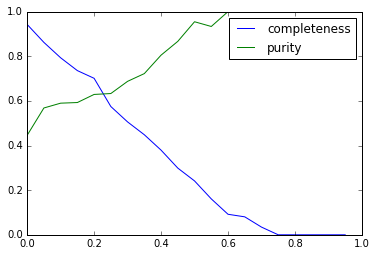

In [21]:
#This is a second way to look at completeness and the probability that region members 
#Are the way they are not due to observational shortcomings
#Nick's probability stuff: purity vs completeness
#Plot spec members to see where probability falls off 
#Do prob cut option for calculation
#%pylab inline
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
Zcut,Ccut= 23.25, 1.5
Pcutmax = 1.0
Pcutmin = 0.0002

#Just do a basic completeness calc given the mag cut for paper
#cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
#Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index

for bina,binb in zip(dic['merger back'],dic['merger front']): # 'unassigned'], ['1','4','7']
    #na=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<Pcut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina].Z.dropna())
    #nb=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<Pcut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb].Z.dropna())
    #resetting index will save 
    Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zamem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zbmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass','pzcdf']].dropna().reset_index()
    #Zanm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zbnm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass','pzcdf']].dropna().reset_index()
    n,bins,patches=py.hist(Zmem.pzcdf,bins=20,alpha=0.4,label='members')
    py.hist(Znm.pzcdf,bins=bins,alpha=0.4,label='nonmembers')
    py.legend()
    #CMD to see how many bright blue galaxies are added if increase
    #Calculate max product for different P threshholds
    completenesses=[]
    purities=[]

    for P in arange(Pcutmin,Pcutmax,0.05):
        Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf>=P)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf>=P)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index

#        Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
#        Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        Zmemall=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        completeness=Zmem.Z.count()*1.0/Zmemall.Z.count()
        purity=Zmem.Z.count()*1.0/(Znm.Z.count()+Zmem.Z.count())*1.0
        completenesses.append(completeness)
        purities.append(purity)
#mpld3.enable_notebook()
%pylab inline
py.figure()
    #print completenesses, purities #,Zmem.Z.count()*1.0/Zmemall.Z.count()
py.plot(arange(Pcutmin,Pcutmax,0.05),completenesses,label='completeness') #decreases as increase threshold
py.plot(arange(Pcutmin,Pcutmax,0.05),purities,label='purity') #increases as increase threshold
py.legend()
#percentage where compromise between completeness and purity is 0.2255 (~0.23) (kind of depends on steps)
#Increasing p(z) threshold means objects must have a larger portion of the p(z) within the LSS redshift range to be considered within the LSS
#As threshold increases (less inclusive), purity increases bc each object is more certainly in LSS
#As threshold increases (less inclusive), completeness decreases bc we are excluding objects that may be members because they have a lower confidence
#So I now make a CMD of pz objects that are not spec confirmed with pzcdf>0.23

In [22]:
#NOTE THIS IS A REPEAT OF THE CELL ABOVE, JUST FOR MAKING HISTOGRAMS

cat_gq.IZ=cat_gq.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_gq.RZ=cat_gq.RZ.replace([np.inf, '-99',-99], np.nan)
cat_gq.RI=cat_gq.RI.replace([np.inf, '-99',-99], np.nan)
#Now do completeness plots based on the slices made above. Here can select and combine particular slices
#Make algorithm to select and combine slices then apply mask...then output to co-add cat or bin co-add cat this way too
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...

#Move this up and do all operations    
    #Did I remove spec galaxies without photometry?
#    print 'All ORELSE galaxies with photozs in pz range:', len( cat_all.xs([cid,'pz'],level=['z_group_pz']).Z )
    #cat_gq.loc[bins_cmd].r
#print cat_gq.loc[['3','2']].r
#print cat_all_temp.xs(['high','cz'],level=['q_group','z_group']).loc[['3','2']].R
#print cat_all_temp.xs(['high','cz'],level=['q_group','z_group']).R
#cat_all=pd.read_csv('/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cat_all_PG.tab',sep='\t')
#Now I should create a CMD for whichever slices (can add many and also combine or change grou names)
#To add two groups (and maybe output cat from here with name)
#big_df.index.names=[u'pops', u'region', u'color', u'EW'] #maybe do this with dupes
#big_df=big_df.reorder_levels([u'pops', u'EW', u'region', u'color'])
#blah=['1','2']
#for a in blah: #FOr grouby object to concat to df maybe
#    print grouped_xbins_i.get_group(str(a))
#cat_gq.loc[['1','2'],:] #select from cat with multi (or columns?), works with 
#cat_gq.loc[('1','3'),['slice','r']]
#cat_gq.rename(index={'1':'core','2':'core'},inplace=True) #rename indices-'2':'core', then select easily for composites or groupby
#xs only works if multiple multiindex, otherwise use cat_gq.loc['core']
#labels=[str(i+1) for i in arange(len(bins)-1)]
#labels=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
#labels2=[['1','13'],['2','3'],['4'],['5','6'],['7'],['8','9','10','11','12'] ]
#labels2_names=[['merger_back'],['2','3','4','5','6'],['merger_front'],['8','9','10','11','12'] ]
hqcz=['high','cz']
hqnz=['high','nz']
hqczpz=['high','cz','pz']
#lqcz=['low','cz']
#lq=['low']
level=['z_group_pz']
level2=['q_group','z_group']
level3=['q_group','z_group','z_group_pz'] #for groupby and stats
#print level3.reverse()
#Apply mask to mid-radial bins to condense to new bins with given name, maybe store as new index:
#print cat_gq.loc[['3','2']].xs(hqcz,level=level2).R
#print cat_gq.loc[['3','2']].xs(['high','cz'],level=['q_group','z_group']).R
##print cat_gq.loc[labels2[0]].groupby(level3).size()
##print cat_gq.loc[:].groupby(level3).size()
'''
for group in labels:
    print group, cat_gq.loc[group].q_group.count(),cat_gq.loc[group].R.count() #3rd one excludes specz where null
    print cat_gq.loc[group].groupby(level3).size()   
Change this to be more like cat_all, pasted fro original coadd groupby output way above here
grouped_xbins_coadd = cat_coadd[['id_spec', 'maskname', 'slit', 'LFC_RA', 'LFC_DEC', 'R', 'I', 'Z', 'redshift', 'z_spec_err', 'q', 'old_id']].groupby(pd.cut(cat_coadd.xprime,bins))

'''
#bins_cmd=[str(i+1) for i in arange(len(bins3)-1)] #string labels 1-13
#This should be ok since order doesn't matter for output of each file if 7 is first
bins_cmd=[i for i in cat_gq.slice_i2.unique()] #string labels 7 to include unassigned
labels_cmd=[i for i in cat_gq.slice.unique()]
print bins_cmd,labels_cmd, targetdir
#binwMpc=[(round(abs(bins[i]-bins[i+1])*dx2Mpc,2),i+1) for i in arange(len(bins)-1)]#print '{:.2f}'.format(zip(*binwMpc)[0])
#binw,n = zip(*binwMpc)[0],zip(*binwMpc)[1] #these won't directly match up if concence bins, so add widths as well
#print bins_cmd.sort() #does this fix order so not 1, 10, 12,13,2...?
#Want to do this for unassigned too so maybe do zip instead of dic
py.rcParams['figure.figsize'] = (10, 7) #Just add this for histograms...may mess up plots of don't run fully and backtrack to other cells
for bin,label in zip(bins_cmd,labels_cmd):
    print bin,label
    cid=str(bin)
    '''
    #quit()
    #figname='CMD bin #'+cid+' '+label
    #1
    #figname='CMD (z=[1.09,1.12] Q=3,4 )'
    #stats= '\n'+str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.xs(hqcz,level=level2).Z))+' confirmed members in structure (black dots)'
    #py.title(figname+stats+stats2,fontsize=14)
    #2
    figname='CMD of '
    stats= str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.loc[bin].Z))+' photometric objects in bin (black dots)'
    #2b pz
    stats2 = '\n'+str(len(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z))+r' $z_{phot}$=$z_{clust}\pm\sigma_{phot}$ photometric objects in bin (black dots)'
    stats3='\n'+str(len(cat_gq.xs(hqnz,level=level2).loc[bin].Z)+len(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z))+r' high Q non-$z_{clust}$ objects in bin (green x) '+'\n'+str(len(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z))+' low Q objects in bin (orange x)'
    py.title(figname+stats+stats2+stats3,fontsize=20)

    #1&2
    #All spec confirmed hq, cz objects in each bin/slice
    py.plot(cat_gq.xs(hqcz,level=level2).loc[bin].Z,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,'bs',mec='b',mfc='w',mew=2,ms=10,alpha=1)
    py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'ms',mec='m',mfc='w',mew=2,ms=10,alpha=1)

    #2
    #All spec confirmed hq, nz objects in each bin/slice, including stars and LRIS (magenta)
    py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].Z,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].Z,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)

    #2
    #All targeted but lq spec objects in each bin/slice (any photoz value pz+nz)
    py.plot(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z,cat_gq.xs(['low'],level=['q_group']).loc[bin].IZ,color='orange',marker='x',mec='darkorange',linestyle='None',mfc='orange',mew=4,ms=7,alpha=1)
    #py.plot(cat_gq.xs(lqcz,level=level2).loc[bin].Z,cat_gq.xs(lqcz,level=level2).loc[bin].IZ,'ox',mec='x',mfc='o',mew=2,ms=10,alpha=1)
    #Should I do untargeted/lowq with photz in pz range? Or lowq with photoz in pz range?
    
    #All photometric objects in LSS FOV with photoz in pz range
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).Z,cat_gq.xs(['pz'],level=['z_group_pz']).IZ,'ko',ms=1,alpha=0.5)

    #2a
    #ALL photometric objects in each bin/slice, no photoz limit use=1 (doesn't include specz without pz match)
    #py.plot(cat_gq.loc[bin].Z,cat_gq.loc[bin].IZ,'ko',ms=0.8)

    #2b
    #All photoemtric objects in each bin slice with photoz in pz/nz range (note many had nz so maybe include all)
    py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=2)
    #py.plot(cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].Z,cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=1,alpha=0.9)

    #1
    #All spec confirmed hq, cz objects in LSS 
    #If you comment this out, then change the x-axis range to allow for all photoz objects 21, 27
    #py.plot(cat_gq.xs(hqcz,level=level2).Z,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)

    filename='CMD_'+cid+'_'+label
    py.ylim((-0.25,1.4))
    #1
    #py.xlim((20.5,24.5))
    #2
    #py.xlim((20,27))
    py.xlim((20,25))

    xmin, xmax = py.xlim()
    ymin, ymax = py.ylim()
    py.text(xmax-1.5, ymax-0.28,cid+' '+label, color='k', fontsize='25')
    py.xlabel(r'$Z$',fontsize=21)
    py.ylabel(r'$I-Z$',fontsize=21)
    #py.tight_layout()
    py.tick_params(axis='both', which='major', labelsize=15)
    #py.savefig(targetdir+'plots/'+filename+'CMDhist',bbox_inches='tight')

    #py.savefig(filename,bbox_inches='tight')
    #py.savefig(filename)

    py.close()
    
    
    #CSMD
    filename='CSMD_'+cid+'_'+label
    py.title(figname)

    #figname='CMD bin #'+cid+' '+label
    #1
    #figname='CSMD (z=[1.09,1.12] Q=3,4 )'
    #stats= '\n'+str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    #stats2 = '\n'+str(len(cat_gq.xs(hqcz,level=level2).Z))+' confirmed members in structure (black dots)'
    #py.title(figname+stats+stats2,fontsize=14)
    #2
    figname='CSMD of '
    stats= str(len(cat_gq.xs(hqcz,level=level2).loc[bin].Z))+' confirmed members in bin '+cid+' '+label
    stats2 = '\n'+str(len(cat_gq.loc[bin].Z))+' photometric objects in bin (black dots)'
    #2b
    #stats2 = '\n'+str(len(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].Z))+r' $z_{phot}$=$z_{clust}\pm\sigma_{phot}$ photometric objects in bin (black dots)'
    stats3='\n'+str(len(cat_gq.xs(hqnz,level=level2).loc[bin].Z)+len(cat_gq.xs(['star'],level=['q_group']).loc[bin].Z))+r' high Q non-$z_{clust}$ objects in bin (green x) '+'\n'+str(len(cat_gq.xs(['low'],level=['q_group']).loc[bin].Z))+' low Q objects in bin (orange x)'
    
    py.title(figname+stats+stats2+stats3,fontsize=16)

    #1&2
    #All spec confirmed hq, cz objects in each bin/slice
    py.plot(cat_gq.xs(hqcz,level=level2).loc[bin].lmass,cat_gq.xs(hqcz,level=level2).loc[bin].IZ,'bs',mec='b',mfc='w',mew=2,ms=10,alpha=1)
    py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].lmass,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'ms',mec='m',mfc='w',mew=2,ms=10,alpha=1)

    #2
    #All spec confirmed hq, nz objects in each bin/slice, including stars and LRIS (magenta)
    py.plot(cat_gq.xs(hqnz,level=level2).loc[bin].lmass,cat_gq.xs(hqnz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    py.plot(cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].lmass,cat_gq[cat_gq.maskname=='T08_LRIS'].xs(hqcz,level=level2).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)
    #py.plot(cat_gq.xs(['star'],level=['q_group']).loc[bin].lmass,cat_gq.xs(['star'],level=['q_group']).loc[bin].IZ,'gx',mec='g',mfc='g',mew=4,ms=7,alpha=0.9)

    #2
    #All targeted but lq spec objects in each bin/slice (any photoz value pz+nz)
    py.plot(cat_gq.xs(['low'],level=['q_group']).loc[bin].lmass,cat_gq.xs(['low'],level=['q_group']).loc[bin].IZ,color='orange',marker='x',mec='darkorange',linestyle='None',mfc='orange',mew=4,ms=7,alpha=1)
    #py.plot(cat_gq.xs(lqcz,level=level2).loc[bin].lmass,cat_gq.xs(lqcz,level=level2).loc[bin].IZ,'ox',mec='x',mfc='o',mew=2,ms=10,alpha=1)
    #Should I do untargeted/lowq with photz in pz range? Or lowq with photoz in pz range?
    
    #All photometric objects in LSS FOV with photoz in pz range
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).lmass,cat_gq.xs(['pz'],level=['z_group_pz']).IZ,'ko',ms=1,alpha=0.5)

    #2
    #ALL photometric objects in each bin/slice, no photoz limit use=1 (doesn't include specz without pz match)
    py.plot(cat_gq.loc[bin].lmass,cat_gq.loc[bin].IZ,'ko',ms=0.8)

    #2b
    #All photoemtric objects in each bin slice with photoz in pz/nz range (note many had nz so maybe include all)
    #py.plot(cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].lmass,cat_gq.xs(['pz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=2)
    #py.plot(cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].lmass,cat_gq.xs(['nz'],level=['z_group_pz']).loc[bin].IZ,'ko',ms=1,alpha=0.9)
    #1
    #All spec confirmed hq, cz objects in LSS 
    #If you comment this out, then change the x-axis range to allow for all photoz objects 21, 27
    #py.plot(cat_gq.xs(hqcz,level=level2).lmass,cat_gq.xs(hqcz,level=level2).IZ,'ko',ms=2,alpha=1)
    #filename='CSMD_'+cid
    py.ylim((-0.25,1.4))
    #1
    #py.xlim((12,9))
    #2
    #py.xlim((12,9))
    py.xlim((12,7.5))
    xmin, xmax = py.xlim()
    ymin, ymax = py.ylim()
    py.text(xmax+1.2, ymax-0.3,cid+' '+label, color='k', fontsize='25')
    py.xlabel(r'$log(M_{*} M_{\odot}^{-1})$', fontsize=21)
    py.ylabel(r'$I-Z$',fontsize=21)
    py.tick_params(axis='both', which='major', labelsize=15)
    #py.tight_layout()
    #py.savefig(targetdir+'plots/'+filename,bbox_inches='tight')
    py.close()
    #print cat_all.loc[bin].groupby(['q_group','z_group']).size()
    '''
    #These include stars q_group. CMDs do not.
    py.close()
    py.figure(2)
    py.subplot(311)
    py.title('Area Normalized I-Z Color and Z Mag (lower Z<23.8) Distributions '+str(bin)+' '+label, fontsize='15')
    py.ylabel('Prob N Galaxies')
    #n, bins, patches = py.hist(cat_gq.loc[bins].dropna().IZ, 50, color='y', alpha=0.5, ec='none', label='All (pz,nz)')
    #print cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].IZ.dropna()
    n, binss, patches = py.hist(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].IZ.dropna(), 25, range=[-0.2, 1.2],color='k', alpha = 0.3,hatch="/", ec='k',normed=True, label='In Photoz Range')
    #if (cat_gq[(cat_gq.q_group=='low')].loc[bin].IZ.dropna().any()!=False):
    #    py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].IZ, binss, color='orange', alpha = 1, ec='none', normed=True, label='Targeted low Q')
    py.hist(cat_gq.xs([ 'high'],level=['q_group']).loc[bin].IZ.dropna(), binss, color='g', alpha=0.3, ec='none', normed=True, label='High Quality Spec-z')
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In')
    #py.hist(cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='g', alpha=0.3, ec='none', normed=True, label='Confirmed Out')
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In')
    #print np.sum(n * np.diff(binss)) #verify total len*width area of bins sums to 1
    py.legend(fontsize='large',loc='upper left')
    #py.legend()
    #py.title('Z Mag Distribution '+label, fontsize='15')
    py.subplot(312)
    py.ylabel('Prob N Galaxies')           
    n, binss, patches = py.hist(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].Z.dropna(), 25, range=[20, 28],color='k', alpha = 0.3,hatch="/",ec='k',normed=True,label='In Photoz Range')
    #if (cat_gq[(cat_gq.q_group=='low')].loc[bin].Z.dropna().any()!=False):
    #    py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].dropna().Z, binss, color='orange', alpha = 1, ec='none', normed=True, label='Targeted low Q')
    n2,binns2, patches2 = py.hist(cat_gq.xs([ 'high'],level=['q_group']).loc[bin].Z.dropna(), binss, color='g', alpha=0.4, ec='none', normed=True, label='High Quality Spec-z')

    
    #py.close()
    #py.legend(fontsize='large',loc='upper left')
    #py.legend()
    #py.title('Z Mag Distribution '+label, fontsize='15')
    py.subplot(313)
    py.ylabel('Prob N Galaxies')           
    n, binss, patches = py.hist(cat_gq[cat_gq.Z<=23.8].xs([ 'pz'],level=['z_group_pz']).loc[bin].Z.dropna(), 25, range=[20, 28],color='k', alpha = 0.3,hatch="/",ec='k',normed=True,label='In Photoz Range')
    #if (cat_gq[(cat_gq.q_group=='low')].loc[bin].Z.dropna().any()!=False):
    #    py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].dropna().Z, binss, color='orange', alpha = 1, ec='none', normed=True, label='Targeted low Q')
    n2,binns2, patches2 = py.hist(cat_gq[cat_gq.Z<=23.8].xs([ 'high'],level=['q_group']).loc[bin].Z.dropna(), binss, color='g', alpha=0.4, ec='none', normed=True, label='High Quality Spec-z')
    #py.hist(cat_gq.xs([ 'high',level=['q_group']).loc[bin].Z.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In LSS')
    #py.hist(cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].Z.dropna(), binss, color='g', alpha=0.3, ec='none', normed=True, label='Confirmed Out')
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].Z.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In LSS')
    #Perform KS test of each distribution relative to normal dist and to each other, maybe then iterate cut to find out at what mag this is minimized to 80%?
    #from scipy.stats import ks_2samp,kstest. One page says we need a cumulative CPD to perform ks-test, another says Chi-sq is better for binned data because KS assumed a continuous dist
    #Not sure meaning of diff between area normed/prob density dist KS test and full distribution, think I'll go with former
    print ks_2samp(n,n2), 'High P-value means we cannot reject hypothesis that they are drawn from the same distribution'
    #print '\nNull hypothesis that 2 independent samples are drawn from the SAME continuous distribution. If the K-S statistic is SMALL or the p-value is HIGH, then we cannot reject the hypothesis that the distributions of the two samples are the SAME.'
    #'Z Mag KS test normed hist (prob dist) versus mag distributions. Percent and confidence'
    #print ks_2samp(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].Z.dropna(),cat_gq.xs([ 'high'],level=['q_group']).loc[bin].Z.dropna())
    #print cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].Z.dropna().max()
    #py.savefig(targetdir+'histZ_norm_hq_'+str(bin)+'_'+label)
    #py.savefig('hist_IZ'+str(bin))
    py.close()
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group','z_group_pz']).loc[bin].dropna().IZ, binss, color='r', alpha=0.4, ec='none', label='Confirmed In LSS and photoz in range')

    py.figure(3)
    py.subplot(211)
    py.title('I-Z Color and Z Mag Distributions '+str(bin)+' '+label, fontsize='15')
    py.ylabel('N Galaxies')
    #n, bins, patches = py.hist(cat_gq.loc[bins].dropna().IZ, 50, color='y', alpha=0.5, ec='none', label='All (pz,nz)')
    #print cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].IZ.dropna()
    n, binss, patches = py.hist(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].IZ.dropna(), 25, range=[-0.2, 1.2],color='k', alpha = 0.3,hatch="/", ec='k',normed=True, label='In Photoz Range')
    if (cat_gq[(cat_gq.q_group=='low')].loc[bin].IZ.dropna().any()!=False):
        py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].IZ.dropna(), binss, color='orange', alpha = 0.5, ec='none', normed=True, label='Targeted low Q')
    #py.hist(cat_gq.xs([ 'high'],level=['q_group']).loc[bin].IZ.dropna(), binss, color='g', alpha=0.3, ec='none', normed=True, label='High Quality Spec-z')
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In')
    py.hist(cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='g', alpha=0.4, ec='none', normed=True, label='Confirmed Out')
    py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].IZ.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In')

    py.legend(fontsize='large',loc='upper left')
    py.subplot(212)
    py.ylabel('N Galaxies')           
    n, binss, patches = py.hist(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].Z.dropna(), 25, range=[20, 28],color='k', alpha = 0.3,hatch="/",ec='k',normed=True,label='In Photoz Range')
    if (cat_gq[(cat_gq.q_group=='low')].loc[bin].Z.dropna().any()!=False):
        py.hist(cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].Z.dropna(), binss, color='orange', alpha = 0.5, ec='none', normed=True, label='Targeted low Q')
    #py.hist(cat_gq.xs([ 'high'],level=['q_group']).loc[bin].Z.dropna(), binss, color='g', alpha=0.4, ec='none', normed=True, label='High Quality Spec-z')
    py.hist(cat_gq.xs([ 'high','nz' ],level=['q_group','z_group']).loc[bin].Z.dropna(), binss, color='g', alpha=0.4, ec='none', normed=True, label='Confirmed Out')
    py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group']).loc[bin].Z.dropna(), binss, color='b', alpha=0.5, ec='none', normed=True, label='Confirmed In')
    #print cat_gq[(cat_gq.q_group!='high')&(cat_gq.q_group.notnull())].loc[bin].Z.dropna().describe()
    #py.savefig(targetdir+'histZ_normCMD_'+str(bin)+'_'+label)
    py.close()
    #py.hist(cat_gq.xs([ 'high','cz'],level=['q_group','z_group','z_group_pz']).loc[bin].dropna().IZ, binss, color='r', alpha=0.4, ec='none', label='Confirmed In LSS and photoz in range')
print 'KS P value goes from infinitesimal to 99% with a mag cut of 23.8'
py.close()
#HISTOGRAMS

['1', '2', '3', '4', '5', '6', '7'] ['merger back', 'infall B', 'core B', 'merger front', 'infall A', 'core A', 'unassigned'] /Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/Rvir_radialg4/
1 merger back
Ks_2sampResult(statistic=0.12, pvalue=0.98963220961632281) High P-value means we cannot reject hypothesis that they are drawn from the same distribution
2 infall B
Ks_2sampResult(statistic=0.12, pvalue=0.98963220961632281) High P-value means we cannot reject hypothesis that they are drawn from the same distribution
3 core B
Ks_2sampResult(statistic=0.16000000000000003, pvalue=0.87741325279801186) High P-value means we cannot reject hypothesis that they are drawn from the same distribution
4 merger front
Ks_2sampResult(statistic=0.16000000000000003, pvalue=0.87741325279801186) High P-value means we cannot reject hypothesis that they are drawn from the same distribution
5 infall A
Ks_2sampResult(statistic=0.19999999999999996, p

Ks_2sampResult(statistic=0.45588235294117646, pvalue=0.021083638646146909) : Z dist High P-value means drawn from the same distribution, Low means different
Ks_2sampResult(statistic=0.27941176470588236, pvalue=0.35955216551873115) : I-Z Dist Ks stat
Ks_2sampResult(statistic=0.29901960784313719, pvalue=0.28133387596936166) : lmass Dist Ks stat
Ks_2sampResult(statistic=0.45588235294117646, pvalue=0.021083638646146909) : Z dist High P-value means drawn from the same distribution, Low means different
Ks_2sampResult(statistic=0.27941176470588236, pvalue=0.35955216551873115) : I-Z Dist Ks stat
Ks_2sampResult(statistic=0.29901960784313719, pvalue=0.28133387596936166) : lmass Dist Ks stat
Region  1  is bigger than  4 :  24 17
Drawing array of size merger front: 17 17 drawn from array of size merger back 24
Do KS test of resampled distribution for Merger Back the size of Merger Front to see if can reproduce
Ks_2sampResult(statistic=0.35294117647058826, pvalue=0.19000763306364221) : Z dist High 

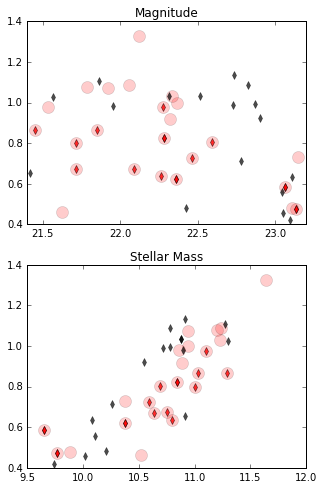

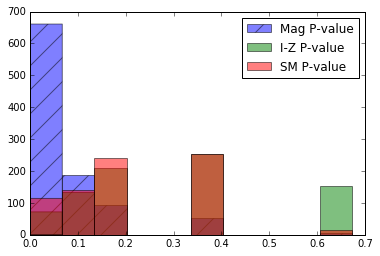

In [23]:
#Do MC resampling, since I only need to do this for two regions at a time ('merger front' and 'merger back'+'Unassigned') Regions 4 and 10 ()
#Do KS test on resampled distributions, could just make a df of these values
#There is no 2D KS test because can't define 2D CDF, except for odd peacock 1987. Should do AD or 2D chisq, but need binning for chisq
#Should reset index so can select random int. Can I easily fix objects for this? Completeness high enough to not to MC?
    #Should be easy to edit size of resampled set, fix certain values fron either dist. 
    #To fix values just reduce sample size and sample, then pd.concat([],ignore_index=True) to series. Note concat doesn't re-index
#Can I reproduce the merger front distribution given random samples of the same size from the merger back?
#First to KZ test of original distributions
Zcut=23.25
#Zcut=22.9
Ccut=1.5
#Ccut=0.92
#Ccut=0.8
py.rcParams['figure.figsize'] = (5, 8)
#sample=[]
ks_statsZ=[]
ks_statsIZ=[]
ks_statslmass=[]
#ks_stats_t=[]
#print str(dic['merger front'])
for bina,binb in zip(dic['merger back'],dic['merger front']): # 'unassigned'], ['1','4','7']
    #n=len(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].IZ.dropna())
    #Make into series of length n, select random values with replacement
    #could make 
    na=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina].Z.dropna())
    nb=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb].Z.dropna())
    #resetting index will save 
    Za=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass']].dropna().reset_index() #reset to give unique index
    Zb=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass']].dropna().reset_index()
    #SMa=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['lmass','IZ']].dropna().reset_index()
    #SMb=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['lmass','IZ']].dropna().reset_index()
    #kstest(Za,Zb) We want a low P-value because this means they are not drawn from the same distribution (can reject hypothesis)
    print ks_2samp(Za.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
    print ks_2samp(Za.IZ,Zb.IZ),': I-Z Dist Ks stat'
    print ks_2samp(Za.lmass,Zb.lmass),': lmass Dist Ks stat'
    print ks_2samp(Za.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
    print ks_2samp(Za.IZ,Zb.IZ),': I-Z Dist Ks stat'
    print ks_2samp(Za.lmass,Zb.lmass),': lmass Dist Ks stat'
    #Do this 1000 times
    #df=Zb #Start with dataframe of original sample as zeroth then index i+1
    #df.index.names='mc' #
    if ( (na>=nb)|(na==nb) ):
        print 'Region ', dic['merger back'],' is bigger than ',dic['merger front'],': ',na, nb
        #n_samples must be less than array of data resampling from..this doesn't make sense if it is with replacement
        #outputs dataframe so can to for Z and IZ at the same time
        #print sklearn.utils.resample(Za,n_samples=len(Zb))
        print 'Drawing array of size merger front:',len(resample(Za,n_samples=len(Zb))),len(Zb),'drawn from array of size merger back',len(Za)
        Zamc=resample(Za,n_samples=len(Zb))
        print 'Do KS test of resampled distribution for Merger Back the size of Merger Front to see if can reproduce'
        #print resample(Za,n_samples=len(Zb)).Z
        print ks_2samp(Zamc.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
        print ks_2samp(Zamc.IZ,Zb.IZ),': I-Z Dist Ks stat'
        print ks_2samp(Zamc.lmass,Zb.lmass),': lmass Dist Ks stat'
        #Example plot of single draw #print Zamc.Z.values
        #'''
        py.figure(1)
        py.subplot(211)
        py.title('Magnitude')
        py.plot(Za.Z, Za.IZ,'ro',ms=12,alpha=0.2)
        py.plot(Zamc.Z, Zamc.IZ,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
        py.plot(Zb.Z, Zb.IZ,'kd',ms=5,alpha=0.7)
        py.subplot(212)
#        py.plot(Za.IZ, Za.Z,'ro',ms=12,alpha=0.2)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
#        py.plot(Zb.IZ, Zb.Z,'kd',ms=5,alpha=0.7)
        py.title('Stellar Mass')
        py.plot(Za.lmass, Za.IZ,'ro',ms=12,alpha=0.2)
        py.plot(Zamc.lmass, Zamc.IZ,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
        py.plot(Zb.lmass, Zb.IZ,'kd',ms=5,alpha=0.7)
        #'''
        for i in range(0,1000):
                Zamc=resample(Za,n_samples=len(Zb))
                ks_statsZ.append(ks_2samp(Zamc.Z,Zb.Z)[1])
                ks_statsIZ.append(ks_2samp(Zamc.IZ,Zb.IZ)[1])
                ks_statslmass.append(ks_2samp(Zamc.lmass,Zb.lmass)[1])
                #ks_stats_t.append(ks_2samp(Zb.IZ,Zb.IZ)[1])
        py.rcParams['figure.figsize'] = (6, 4)
        py.figure(2)
        n,binss,patches=py.hist(ks_statsZ,hatch='/',alpha=0.5,label='Mag P-value')
        #py.hist(ks_statsIZ,bins=binss,alpha=0.5,label='Color P-value')
        py.hist(ks_statsIZ,bins=binss,alpha=0.5,label='I-Z P-value')
        py.hist(ks_statslmass,bins=binss,alpha=0.5,label='SM P-value')
        py.legend()
        #How many unique P-values can we have for N=18? I guess not very many?
        #print ks_stats_t
        #py.subplot(211)
        #n,binss,patches=py.hist(Zamc.Z,alpha=0.5)
        #py.hist(Zb.Z,bins=binss,alpha=0.5)
        #py.subplot(212)
        #n,binss,patches=py.hist(Zamc.IZ,alpha=0.5)
        #py.hist(Zb.IZ,bins=binss,alpha=0.5)
        #df_it.index=i+1
        #df=pd.concat[df]
        #df_it=pd.concat([df_it,],keys=)
        #ks_stats.append()
    else: print 'SWAP SIZES manually cause I dont want to paste this and make it super long'
        #ZA.loc[sklearn.utils.resample(ZA,n_samples=len(ZC)).index]
        #ZB=cat_all.xs([ 'high','cz'],level=['q_group','z_group']).Z.dropna().reset_index().tail()
        #sample=np.append(sample,sample0)
#Will have to reset index to slice if want, then plot Z, IZ

1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
  [0.12917896207402116, 0.16430580776895826]
I-Z color merger back (red), front (blue): 
[0.057266507521358118, 0.076927294971369062]
Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]
STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue) [10.85, 10.78] [0.8145, 0.982]
0.494718606887 19.790158853 0.345403431477 0.4655 0.1675 0.209006226484 0.0959023544826
x projection of d / 1*sigx (x1,x2 in quad) /  2.22720637481
y projection of d / 1*sigy (y1,y2 in quad) /  1.74656817243


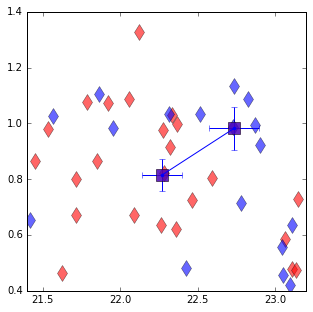

In [24]:
#%pylab inline
py.close
py.rcParams['figure.figsize'] = (5, 5)
#print [1./np.sqrt(len(Za.Z)),1./np.sqrt(len(Zb.Z))] #This is for error on the mean, which tells us how well the mean of this sample estimates the actual mean of the larger pop
#print [1./np.sqrt(len(Za.Z))/2 + 1./np.sqrt(len(Zb.Z)/2)]
#print 'distance between means is: ',np.sqrt(  (Za.Z.mean()-Zb.Z.mean())**2 + (Za.IZ.mean()-Zb.IZ.mean())**2)
#print 'distance between medians is: ',np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#d=np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#theta=
#x,y=d*np.sin(theta*np.pi/180) , d*np.cos(theta*np.pi/180)
#print 'standard dev of Z mag merger back (red), front (blue):',[Za.Z.std(),Zb.Z.std()]
#print 'standard dev of I-Z color merger back (red), front (blue):',[Za.IZ.std(),Zb.IZ.std()]
print '1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):\n ',[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))]
print 'I-Z color merger back (red), front (blue): \n'  ,[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))]
print 'Medians, Z (red,blue), I-Z (red,blue)',[Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()]
print 'STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue)',[Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()]
py.plot(Za.Z, Za.IZ,'rd',ms=12,alpha=0.6)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
py.plot(Zb.Z, Zb.IZ,'bd',ms=12,alpha=0.6)
Zb[['Z','IZ']].to_csv('Red_MF_CMD.tab',sep='\t',index=False)
Za[['Z','IZ']].to_csv('Blue_MB_CMD.tab',sep='\t',index=False)
#py.plot([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],'rs',ms=12,alpha=0.6)
#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)
py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)
#Relate uncertainty on the mean to median with 1.253 from Hathi 2016
py.errorbar([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],xerr=[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))],yerr=[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))],marker='.'  )
#py.errorbar([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],xerr=[Za.Z.std(),Zb.Z.std()],yerr=[Za.IZ.std(),Zb.IZ.std()],marker='.'  )
#py.savefig('2Dmedian.png')
#Calculate the projection of the sum of x and y errors onto the line between the points using dot product
d=np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
dx, dy=abs(Za.Z.median()-Zb.Z.median()) ,abs(Za.IZ.median()-Zb.IZ.median())
theta=math.degrees(math.atan(dy/dx))
sigx=np.sqrt( (1.253*Za.Z.std()/np.sqrt(len(Za.Z)))**2 + (1.253*Zb.Z.std()/np.sqrt(len(Zb.Z)))**2 )
sigy=np.sqrt( (1.253*Za.IZ.std()/np.sqrt(len(Za.Z)))**2 + (1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z)))**2 )
print d,theta,math.atan(dy/dx),dx,dy,sigx,sigy
print 'x projection of d / 1*sigx (x1,x2 in quad) / ',dx/sigx
print 'y projection of d / 1*sigy (y1,y2 in quad) / ',dy/sigy

#print 'projection of sigx1 and sigx2 along d: sigx*d*cos(theta)',sigx*d*cos(math.radians(theta))
#print 'projection of sigy1 and sigy2 along d: sigy*d*sin(theta)',sigy*d*sin(math.radians(theta))
#print 'sum: ',sigx*d*sin(math.radians(theta))+sigy*d*cos(math.radians(theta))
#py.plot([Za.Z.median(),Za.Z.median()+sigx*d*sin(math.radians(theta))], [Za.IZ.median(),Za.IZ.median()+sigy*d*cos(math.radians(theta))],'r-') #should I also do median? Median is better if there are lot of outliers


1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
  [0.12917896207402116, 0.16430580776895826]
I-Z color merger back (red), front (blue): 
[0.057266507521358118, 0.076927294971369062]
Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]
STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue) [10.85, 10.78] [0.8145, 0.982]
0.181538563396 67.319440393 1.17494588546 0.07 0.1675 0.18590476556 0.0959023544826
x projection of d / 1*sigx (x1,x2 in quad) /  0.376536877842
y projection of d / 1*sigy (y1,y2 in quad) /  1.74656817243


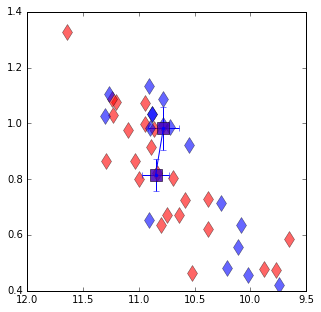

In [25]:
#Calculating uncertainty on the median to check difference between the two distributions
py.close
py.rcParams['figure.figsize'] = (5, 5)
#print [1./np.sqrt(len(Za.Z)),1./np.sqrt(len(Zb.Z))] #This is for error on the mean, which tells us how well the mean of this sample estimates the actual mean of the larger pop
#print [1./np.sqrt(len(Za.Z))/2 + 1./np.sqrt(len(Zb.Z)/2)]
#print 'distance between means is: ',np.sqrt(  (Za.Z.mean()-Zb.Z.mean())**2 + (Za.IZ.mean()-Zb.IZ.mean())**2)
#print 'distance between medians is: ',np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#d=np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#x,y=d*np.sin(theta*np.pi/180) , d*np.cos(theta*np.pi/180)
#print 'standard dev of Z mag merger back (red), front (blue):',[Za.Z.std(),Zb.Z.std()]
#print 'standard dev of I-Z color merger back (red), front (blue):',[Za.IZ.std(),Zb.IZ.std()]
print '1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):\n ',[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))]
print 'I-Z color merger back (red), front (blue): \n'  ,[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))]
print 'Medians, Z (red,blue), I-Z (red,blue)',[Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()]
print 'STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue)',[Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()]
#py.plot(Za.Z, Za.IZ,'rd',ms=12,alpha=0.6)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
#py.plot(Zb.Z, Zb.IZ,'bd',ms=12,alpha=0.6)
py.plot(Za.lmass, Za.IZ,'rd',ms=12,alpha=0.6)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
py.plot(Zb.lmass, Zb.IZ,'bd',ms=12,alpha=0.6)
#py.plot([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],'rs',ms=12,alpha=0.6)
#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)
py.plot([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
py.plot([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
#py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
#py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)
#Relate uncertainty on the mean to median with 1.253 from Hathi 2016
py.errorbar([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],xerr=[1.253*Za.lmass.std()/np.sqrt(len(Za.lmass)),1.253*Zb.lmass.std()/np.sqrt(len(Zb.lmass))],yerr=[1.253*Za.IZ.std()/np.sqrt(len(Za.lmass)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.lmass))],marker='.'  )
py.gca().invert_xaxis()
#py.errorbar([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],xerr=[Za.Z.std(),Zb.Z.std()],yerr=[Za.IZ.std(),Zb.IZ.std()],marker='.'  )
py.savefig('2DmedianLmass.png')
#Calculate the projection of the sum of x and y errors onto the line between the points using dot product
d=np.sqrt(  (Za.lmass.median()-Zb.lmass.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
dx, dy=abs(Za.lmass.median()-Zb.lmass.median()) ,abs(Za.IZ.median()-Zb.IZ.median())
theta=math.degrees(math.atan(dy/dx))
sigx=np.sqrt( (1.253*Za.lmass.std()/np.sqrt(len(Za.lmass)))**2 + (1.253*Zb.lmass.std()/np.sqrt(len(Zb.lmass)))**2 )
sigy=np.sqrt( (1.253*Za.IZ.std()/np.sqrt(len(Za.lmass)))**2 + (1.253*Zb.IZ.std()/np.sqrt(len(Zb.lmass)))**2 )
print d,theta,math.atan(dy/dx),dx,dy,sigx,sigy
print 'x projection of d / 1*sigx (x1,x2 in quad) / ',dx/sigx
print 'y projection of d / 1*sigy (y1,y2 in quad) / ',dy/sigy
#print 'projection of sigx1 and sigx2 along d: sigx*d*cos(theta)',sigx*d*cos(math.radians(theta))
#print 'projection of sigy1 and sigy2 along d: sigy*d*sin(theta)',sigy*d*sin(math.radians(theta))
#print 'sum: ',sigx*d*sin(math.radians(theta))+sigy*d*cos(math.radians(theta))
#py.plot([Za.Z.median(),Za.Z.median()+sigx*d*sin(math.radians(theta))], [Za.IZ.median(),Za.IZ.median()+sigy*d*cos(math.radians(theta))],'r-') #should I also do median? Median is better if there are lot of outliers


3!= 6.0 = e^(ln[gamma(4)]) = 6
120.0
4.03291461127e+26
24.0
0.994376487882
0.00562351211827
1.0
0.112754082424
0.520357177501
0.842681743299
0.999999999998
-0.112754082424
-0.520357177501
-0.842681743299
-0.999999999998
36.4981663726
0.999329074744


KS stat d (max CDF diff), p-value prob (small means different):  [0.4191176470588235, 0.06557752912675287]
<type 'numpy.ndarray'>
Big Delta:  120.346599533


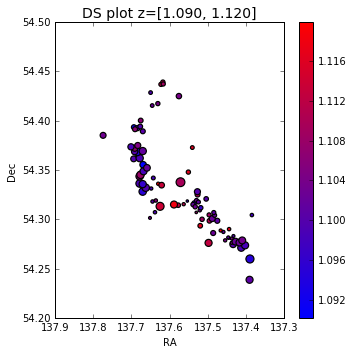

In [26]:
#Run a DS test
from cluster_tools.scic_stat_tests import ks2d2s
import cluster_tools.scic_stat_tests
import cluster_tools.scic_dist_functions as scic_dist
reload(scic_dist)
reload(cluster_tools.scic_stat_tests)
reload(t)
#my_ksdist = scic_dist.KSdist()
#print my_ksdist.pks(1.0)
#print my_ksdist.pks(2.0)
Zcut=23.25
#Zcut=25
#Zcut=22.9
#Ccut=0.92
Ccut=1.5
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...

for bina,binb in zip(dic['merger back'],dic['merger front']): # 'unassigned'], ['1','4','7']
    #print bina,binb
    Za=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass','redshift','alpha','delta']].dropna().reset_index() #reset to give unique index
    Zb=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass','redshift','alpha','delta']].dropna().reset_index()
    #print ks_2samp(Za.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
    #print ks_2samp(Za.IZ,Zb.IZ),': I-Z Dist Ks stat'
    #print ks_2samp(Za.lmass,Zb.lmass),': lmass Dist Ks stat'
O=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).dropna().reset_index(drop=True)
#absolute max distance (supremum) between the CDFs of the two samples
#reject hypothesis if less than sig level
#Small values of prob show that the two samples are significantly different
a=ks2d2s(Za.Z.values,Za.IZ.values,Zb.Z.values,Zb.IZ.values)
#a=ks2d2s(Za.Z.values,Za.IZ.values,Zb.IZ.values,Zb.Z.values)
print '\n\nKS stat d (max CDF diff), p-value prob (small means different): ',a
DSmb=Za[['alpha','delta','redshift']]
#print Za
DSmf=Zb[['alpha','delta','redshift']]
py.close()
#t.dstest( DSmb.T.values[0], DSmb.T.values[1], DSmb.T.values[2] )
#t.dstest( DSmf.T.values[0], DSmf.T.values[1], DSmf.T.values[2] )
DSmbmf=pd.concat([DSmb,DSmf])
#t.dstest( DSmbmf.T.values[0], DSmbmf.T.values[1], DSmbmf.T.values[2] )
O=O[['alpha','delta','redshift']]
t.dstest( O.T.values[0], O.T.values[1], O.T.values[2] )
#py.savefig('DStest.png')
#2D
#no color cut
#KS stat d (max CDF diff), p-value prob (small means different):  
#[0.4191176470588235, 0.06557752912675287] 7%
#with color cut
#[0.5044642857142857, 0.10475045278638723] 10%

#1D without color cut
#Ks_2sampResult(statistic=0.45588235294117646, pvalue=0.021083638646146909) : Z dist High P-value means drawn from the same distribution, Low means different
#Ks_2sampResult(statistic=0.27941176470588236, pvalue=0.35955216551873115) : I-Z Dist Ks stat
#Ks_2sampResult(statistic=0.2475490196078432, pvalue=0.51317176027672962) : lmass Dist Ks stat

#1D with color cut
#Ks_2sampResult(statistic=0.48214285714285715, pvalue=0.14469448029426391) : Z dist High P-value means drawn from the same distribution, Low means different
#Ks_2sampResult(statistic=0.5, pvalue=0.11870973661946686) : I-Z Dist Ks stat
#Ks_2sampResult(statistic=0.6696428571428571, pvalue=0.012622879644914993) : lmass Dist Ks stat


0    -8.092876
1    -2.480884
2    -6.012866
3    -5.165279
4   -16.822099
5    -2.744867
6   -55.092320
Name: EWOIIbp, dtype: float64 0    0.298176
1    0.255500
2    0.556861
3    0.462521
4    0.528491
5    1.045444
6    4.525073
Name: EWOIIerrbp, dtype: float64
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: region, dtype: object
slice_i2
1    1
2    2
3    3
4    4
5    5
6    6
7    7
Name: slice_i2, dtype: object
-5.1652794
-8.0928757


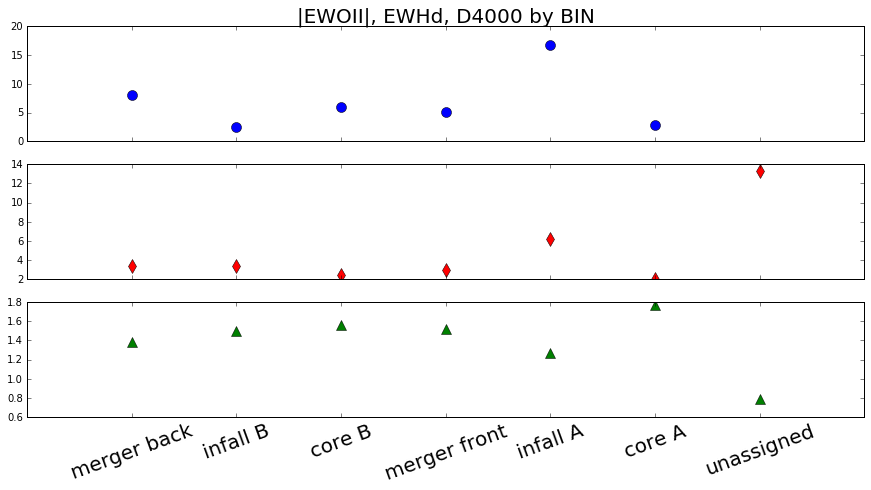

In [27]:
#1) RUN IDL SCRIPT FROM WITHIN CORRECT FITS FOLDER
#2) MOVE ALL EW CATS TO coadd_EW FOLDER
#bins_cmd_int=[int(i) for i in cat_gq.slice_i2.unique()] #string labels 7 to include unassigned
#labels_cmd=[i for i in cat_gq.slice.unique()]
labels_ew=['merger back','infall B','core B','merger front','infall A','core A','unassigned'] #conpare 1+13 to see how diff they are
bins_ew=['1','2','3','4','5','6','7'] #This is to assign new bin numbers for coadd program if don't want to use string names
ticks_ew=np.array([1,2,3,4,5,6,7]) #This is to assign new bin numbers for coadd program if don't want to use string names
#%pylab inline
pylab.rcParams['figure.figsize'] = (15, 7)
folder='Rvir_radialg4'
file_bp='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/coadd_EW/'
D4000=pd.read_table(file_bp+'D4000.tab',header=None, names=['region','D4000','D4000err','title'])
EWOII=pd.read_table(file_bp+'EWOII.tab',header=None, names=['region','EWOIIbp','EWOIIerrbp','title'])
EWHd=pd.read_table(file_bp+'EWHd.tab',header=None, names=['region','EWHdbp','EWHderrbp','title'])
EWOII['region']=EWOII.region.str.lstrip('coadd_cat_gqz_IDL_').str.rstrip('.fits')
EWHd['region']=EWHd.region.str.lstrip('coadd_cat_gqz_IDL_').str.rstrip('.fits')
D4000['region']=D4000.region.str.lstrip('coadd_cat_gqz_IDL_').str.rstrip('.fits')
print EWOII.EWOIIbp,EWOII.EWOIIerrbp
print EWOII.region
ax1 = plt.subplot(311)
py.title('|EWOII|, EWHd, D4000 by BIN',fontsize='20')
#fig.subplots_adjust(hspace=0)
py.plot(EWOII.region,abs(EWOII.EWOIIbp),'bo',ms=10)
#py.errorbar(EWOII.region,abs(EWOII.EWOIIbp),yerr=EWOII.EWOIIerrbp)
py.ylim(0, 20)
#ax1.set_xlim(0, 7)
py.setp(ax1.get_xticklabels(), visible=False)
# share x only
ax2 = plt.subplot(312, sharex=ax1)
py.plot(EWHd.region,EWHd.EWHdbp,'rd',ms=10)
# make these tick labels invisible
py.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(313, sharex=ax1)
py.plot(D4000.region,D4000.D4000,'g^',ms=10)
my_xticks = labels_ew
py.xticks(ticks_ew,my_xticks,rotation=20)
#my_xticks = ['Outskirts','B outer','B mid','B core','Front','A outer','A mid','A Core']
#py.xticks(np.array([1,2,3,4,5,6,7,8]),my_xticks,rotation=70)
py.setp(ax3.get_xticklabels(), fontsize='20')
py.xlim(0, len(EWOII)+1)
#py.savefig(file_bp+'EW')
#print EWHd
#mpld3.enable_notebook()
#cat_pzb.reset_index(inplace=True)
#EWOII.reset_index(inplace=True)
#EWOII.columns=['slice_i2']
#EWOII['slice_i2']=EWOII['slice_i2']+1
#EWOII.set_index('slice_i2',drop=False,inplace=True)
EWOII['slice_i2']=EWOII['region']#.astype('int64')
EWOII.set_index('slice_i2',inplace=True,drop=False)
print EWOII.slice_i2
#print EWOII.EWOIIbp,EWOII.region #,
#print EWOII.loc[1].EWOIIbp , EWOII.loc[4].EWOIIbp
print EWOII.loc[dic['merger front']].EWOIIbp
print EWOII.loc[dic['merger back']].EWOIIbp

#print EWOII.EWOIIbp,EWOII.EWOIIerrbp


In [28]:
# #JUNE5th: Now we care about U band restframe mags and EWOII
#Need <EWOII>, A_v, for <M_u'> need to convert rest frame flux to abs mag with distance modulus I guess
#DM               Distance modulus restflux_[band]
#Observed flux depends on distance (W/m^s). P and L the same but 4*pi/r^2 so double distance flux falls by 4. Luminosity distance
#mv-Mv (Dist mod) = -5 + 5 log10(d), d in pc so D_lum/10pc, mv apparent mag, Mv absolute mag.
# D_lum=(1+z)*D_comoving, D_c is btwn  objects at same redshift but separated in sky
#100 times brighter is 5 mags lower, ten times brighter is 2.5 mags lower
#f1/f2=10^-0.4(m1-m2) ratio of 100 is 5 mags diff, ratio of 10 is 2.5, 10^2=100, 2.5*2=5, log(1/10)=2.5*(1). If ratio is small, flux dimmer (f1<f2), mag diff must be negative, but m2 is smaller number so to make the diff neg, add *(-1): -1* (small(brighter,m2)-big(faint, m1)) is +, so add negative sign from other side=-(m2-m1)
#restflux_U  errflux_U  restflux_B  errflux_B DM
#m_u=-2.5*np.log10(restflux_U)
#m_u-M_u=DM, M_u_mean=m_u_mean-DM.sum()
#To take mean have to add in flux space anyway, so take mean flux
#from cat_all[(cat_all.q_group=='high')&(cat_all.z_group=='cz')].DM.dropna().mean(), sample value for cz
#Find distance modulus of single hq cz object in bin 
DM=43.5250505050505 #mean DM for LSS hq objects
c_cm=3*10**10 #Units km/s e5, m/s e8
Rv=4.05 #pm 0.80
lam=0.3727 #microns from Calzetti 2000 eq (4)
k_lam= 2.659* ( -2.156 + 1.509/lam - 0.198/pow(lam,2) + 0.011/pow(lam,3)) + Rv
lam_5488=0.5488
k_lam_5488= 2.659* ( -2.156 + 1.509/lam_5488 - 0.198/pow(lam_5488,2) + 0.011/pow(lam_5488,3)) + Rv

lam_eff = 3543e-8 #cm
#print cat_coadd.slice_i2.head()
#cat_coadd['slice_i2']=cat_coadd['slice_i2'] #.astype('int64')
#cat_coadd.set_index(['slice_i2'],drop=False,inplace=True)
#print cat_coadd.index
#cat_coadd.loc[1].restflux_U.mean()


#print EWOII.EWOIIbp #,cat_coadd.slice_i2 #is negative, which Brian's convention assumes
#print dic
#EWOII.set_index('slice_i2',inplace=True,drop=False)

for bina,binb in zip(dic['merger back'],dic['merger front']): 

    print '\nmerger back',dic['merger back'] 
    flux_u_mean=cat_coadd.loc[bina].restflux_U.mean()
    flux_u_mean_err=cat_coadd.loc[bina].errflux_U.mean()    
    Av_mean=cat_coadd.loc[bina].Av.mean()
    M_u_mean=-2.5*np.log10(flux_u_mean) + 25 - DM #25 is from Adam's AB zeropoint in readme
    M_u_mean_err = -2.5*flux_u_mean_err/np.log(10)/flux_u_mean #25 is from Adam's AB zeropoint in readme
    #for wavelength range s(0.12-0.63 mm) 3.5307427778227973
    const=0.8 #combination of local and high z methods for calibrating attenuation in conversion between stellar and nebular emission
    EBV= Av_mean / Rv / const #EVBs=0.8*EBV=Av/Rv because magic
    
    #Acont = Av_mean /(k_lam_5488/k_lam)
    Acont = Av_mean *(k_lam/k_lam_5488)
    Aext=0.9 * Acont - 0.15 * Acont**2
    Atten=10**(0.4*EBV*k_lam) #Calzetti 2000
    Atten_w=10**(0.4*Acont)*10**(0.4*Aext) #Calzetti 2000
    print 'Av, Acont, Aext: ', Av_mean,Acont, Aext    
    print 'Correction Wuyts 2013 vs EBV:', Atten_w, Atten #,Acont, Aext, EBV
    
    #eq (5) Lemaux 2014 note constant is pm 0.63
    SFR=-2.51*10**(-10) * 10**( -(M_u_mean+48.6)/2.5 ) * ( c_cm / lam_eff**2) 
    #SFRerr=0.63*10**(-10) * 10**( -(M_u_mean+48.6)/2.5 ) * ( c_cm / lam_eff**2) * (-0.4*np.log(10)*M_u_mean_err)
    SFRmu=10**( -(M_u_mean+48.6)/2.5 ) 
    SFRmuerr= M_u_mean_err / ( ( 10**(-(M_u_mean+48.6)/2.5 ))* np.log(10) )
    #constSFR=10**(-10)*( c_cm / lam_eff**2)
    #print 'constant in front of SFR: ', constSFR
    #Add 0.63 and EWOII error using propagation, here without mu error which is tiny
    #NOTE: constant isn't X+a*dx, it is a (a*(X+dx)) so it cancells out when included as fractional error 
    err=np.sqrt( (0.63/ 2.51 )**2 + (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2 )
    print 'SFR=const*Mu_component*EWOII: ',SFR*EWOII.loc[bina].EWOIIbp
    #err=np.sqrt( (0.63/ ((10**(-10)*( c_cm / lam_eff**2))*2.51) )**2 + (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2 + (SFRmuerr/SFRmu)**2)
    #print 'Mu error propagated, not final added in quad: ',SFRerr
    print 'SFR component, EWOII comp, Mu comp : ',(0.63/ 2.51), (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp ),SFRmuerr/SFRmu
    print 'SFR component, EWOII comp, Mu comp sq: ',(0.63/ 2.51)**2, (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2,(SFRmuerr/SFRmu)**2

    #print 'Err for all three: 0.63 and EWOIIerrbp Mu propagated: ', np.sqrt( (0.63/ ((10**(-10)*( c_cm / lam_eff**2))*2.51) )**2 + (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2 + (SFRmuerr/SFRmu)**2)
    print 'Fractional error times std error: err*SFR*EWOII: ',err*SFR*EWOII.loc[bina].EWOIIbp
    #print 'Fractional error times std error: err*SFR*constSFR: ',(err*SFR)

    print '\nErr*correction to go with F=SFR*correction: ', ( (err*SFR*EWOII.loc[bina].EWOIIbp) )*Atten
    print 'Err*correction to go with F=SFR*correction_WUYTS: ', ( (err*SFR*EWOII.loc[bina].EWOIIbp) )*Atten_w
        
    print '\nSFR extincted',SFR*EWOII.loc[bina].EWOIIbp*Atten
        
    print 'SFR extincted Wuyts (before converting with /1.72 to chabrier):',SFR*EWOII.loc[bina].EWOIIbp*Atten_w

    #print 'SFR with only linear EWOIIerr:',SFRerr*EWOII.loc[bina].EWOIIerrbp*Atten
    #print '\nAttenuation: ',Atten
    print 'Flux, flux mean error:',flux_u_mean,cat_coadd.loc[bina].errflux_U.mean()
    print 'Mu, Mu error: ',M_u_mean,M_u_mean_err
    print 'EWOIIbp ERROR:',EWOII.loc[bina].EWOIIbp,EWOII.loc[bina].EWOIIerrbp

    #print 'SFR(EWOII), <M_u>, E(B-V), k_lam,Av:',SFR*EWOII.loc[bina].EWOIIbp, M_u_mean, EBV,k_lam,Av_mean
    #print '\nEWOIIbp ERROR: SFR extincted',SFR*EWOII.loc[bina].EWOIIerrbp*(-1.0)*Atten
    print '\nUsing constant of prop for stellar to nebular: ',const
    
    
    #completeness is different from represetative-percentage versus squewed
    print '\nmerger front',dic['merger front']    

    flux_u_mean=cat_coadd.loc[binb].restflux_U.mean()
    flux_u_mean_err=cat_coadd.loc[binb].errflux_U.mean()    
    Av_mean=cat_coadd.loc[binb].Av.mean()
    M_u_mean=-2.5*np.log10(flux_u_mean) + 25 - DM #25 is from Adam's AB zeropoint in readme
    M_u_mean_err = -2.5*flux_u_mean_err/(np.log(10)*flux_u_mean) #25 is from Adam's AB zeropoint in readme
    #for wavelength range s(0.12-0.63 mm) 3.5307427778227973
    const=0.8 #combination of local and high z methods for calibrating attenuation in conversion between stellar and nebular emission
    EBV= Av_mean / Rv / const #EVBs=0.8*EBV=Av/Rv because magic
        
    #Acont = Av_mean /(k_lam_5488/k_lam)
    Acont = Av_mean *(k_lam/k_lam_5488)
    Aext=0.9 * Acont - 0.15 * Acont**2
    Atten=10**(0.4*EBV*k_lam) #Calzetti 2000
    Atten_w=10**(0.4*Acont)*10**(0.4*Aext) #Calzetti 2000
    print 'Av, Acont, Aext: ', Av_mean,Acont, Aext    
    print 'Correction Wuyts 2013 vs EBV:', Atten_w, Atten #,Acont, Aext, EBV
    

    #Acont = Av_mean 
    #Acont = Av_mean / Rv
    #Aext=0.9 * Acont - 0.15 * Acont**2
    #Atten=10**(0.4*EBV*k_lam) #Calzetti 2000
    #Atten_w=10**(0.4*Acont*k_lam)*10**(0.4*Aext*k_lam) #Calzetti 2000
    #print 'Atten Wuyts 2013:', Atten_w, Atten,Acont, Aext, EBV

    #eq (5) Lemaux 2014 note constant is pm 0.63
    SFR=-2.51*10**(-10) * 10**( -(M_u_mean+48.6)/2.5 ) * ( c_cm / lam_eff**2) 
    #SFRerr=0.63*10**(-10) * 10**( -(M_u_mean+48.6)/2.5 ) * ( c_cm / lam_eff**2) * (-0.4*np.log(10)*M_u_mean_err)
    #SFRmu=10**( -(M_u_mean+48.6)/2.5 )
    #SFRmuerr=10**( -(M_u_mean+48.6)/2.5 ) * (-0.4*np.log(10)*M_u_mean_err) 
    #Add 0.63 and EWOII error using propagation, then with 
    #err=np.sqrt( (0.63/ 2.51 )**2 + (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2 )
    #err=np.sqrt( (0.63/ (10**(-10)*( c_cm / lam_eff**2)*Atten)*2.51 )**2 + (EWOII.loc[binb].EWOIIerrbp/EWOII.loc[binb].EWOIIbp )**2 + (SFRmuerr/SFRmu)**2)
    #err=np.sqrt( (0.63/ (10**(-10)*( c_cm / lam_eff**2))*2.51 )**2 + (EWOII.loc[binb].EWOIIerrbp/EWOII.loc[binb].EWOIIbp )**2 + (SFRmuerr/SFRmu)**2)
    SFRmu=10**( -(M_u_mean+48.6)/2.5 ) 
    SFRmuerr= M_u_mean_err / ( ( 10**(-(M_u_mean+48.6)/2.5 ))* np.log(10) )
    #constSFR=10**(-10)*( c_cm / lam_eff**2)
    #print 'constant in front of SFR: ', constSFR
    #Add 0.63 and EWOII error using propagation, here without mu error which is tiny
    #NOTE: constant isn't X+a*dx, it is a (a*(X+dx)) so it cancells out when included as fractional error 
    err=np.sqrt( (0.63/ 2.51 )**2 + (EWOII.loc[bina].EWOIIerrbp/EWOII.loc[bina].EWOIIbp )**2 )
    print 'SFR=SFR*EWOII: ',SFR*EWOII.loc[bina].EWOIIbp

    #print 'Mu error propagated, component in quad bf sqrt: ',SFRmuerr,(SFRmuerr/SFRmu)**2
    #print 'EWOII, in quad', EWOII.loc[binb].EWOIIerrbp,(EWOII.loc[binb].EWOIIerrbp/EWOII.loc[binb].EWOIIbp )**2
    #print 'SFR constant error: ',0.63,(0.63/ 2.51 )**2,(0.63/ (10**(-10)*( c_cm / lam_eff**2))*2.51 )**2 
    #print 'EWOIIbp, ERROR',EWOII.loc[binb].EWOIIbp,EWOII.loc[binb].EWOIIerrbp
    
    #print '\nErr for all three: 0.63 and EWOIIerrbp Mu propagated, no Atten: ', np.sqrt( (0.63/ ((10**(-10)*( c_cm / lam_eff**2))*2.51) )**2 + (EWOII.loc[binb].EWOIIerrbp/EWOII.loc[binb].EWOIIbp )**2 + (SFRmuerr/SFRmu)**2)
    #print 'Err for all three prop w attenuation:  ', err*Atten
    print 'Fractional error times std error: err*SFR*EWOII: ',err*SFR*EWOII.loc[binb].EWOIIbp
    #print 'Fractional error times std error: err*SFR*constSFR: ',(err*SFR)

    print '\nErr*correction to go with F=SFR*correction: ', ( (err*SFR*EWOII.loc[binb].EWOIIbp) )*Atten
    print 'Err*correction to go with F=SFR*correction_WUYTS: ', ( (err*SFR*EWOII.loc[binb].EWOIIbp) )*Atten_w

    #0.63 is 25% error on SFR, 1-2% error from flux 100 MC, EWOII is also 2-5% so ~25%
    
    #    print 'SFR(EWOII), Attenuation factor, <M_u>, E(B-V):',SFR*EWOII.loc[bina].EWOIIbp,Atten,M_u_mean, EBV
    #flux_u_mean=cat_coadd.loc[binb].restflux_U.mean()
    #Av_mean=cat_coadd.loc[binb].Av.mean()
    #M_u_mean=-2.5*np.log10(flux_u_mean) + 25 - DM #25 is from Adam's AB zeropoint in readme
    #M_u_mean_err=
    #for wavelength range s(0.12-0.63 mm) 3.5307427778227973
    #const=0.8
    #EBV= Av_mean / Rv / const #EVBs=0.8*EBV=Av/Rv because magic
    #Atten=10**(0.4*EBV*k_lam)
    #eq (5) Lemaux 2014 note constant is pm 0.63
    #SFR=-2.51*10**(-10) * 10**( -(M_u_mean+48.6)/2.5 ) * ( c_cm / lam_eff**2)  
    
    print '\nSFR extinction corrected',SFR*EWOII.loc[binb].EWOIIbp*Atten
            
    print 'SFR extinction corrected Wuyts with out /1.72:',SFR*EWOII.loc[binb].EWOIIbp*Atten_w

    #print '\nAttenuation:',Atten
    #print 'FLUX mean error not propagated:',cat_coadd.loc[binb].errflux_U.mean()
    print 'SFR(EWOII), <M_u>, E(B-V), k_lam, Av:',SFR*EWOII.loc[binb].EWOIIbp,M_u_mean, EBV,k_lam,Av_mean
    #print '\nEWOIIbp ERROR: SFR extincted',SFR*EWOII.loc[binb].EWOIIerrbp*(-1.0)*Atten

    print '\n'
  


merger back 1
Av, Acont, Aext:  0.634782608696 0.916461019252 0.698829797356
Correction Wuyts 2013 vs EBV: 4.42706936419 2.87783130059
SFR=const*Mu_component*EWOII:  0.368830103375
SFR component, EWOII comp, Mu comp :  0.250996015936 -0.0368442789749 -1.61637299644e+20
SFR component, EWOII comp, Mu comp sq:  0.0629990000159 0.00135750089318 2.61266166363e+40
Fractional error times std error: err*SFR*EWOII:  0.0935669713154

Err*correction to go with F=SFR*correction:  0.269269958753
Err*correction to go with F=SFR*correction_WUYTS:  0.414227472211

SFR extincted 1.06143081609
SFR extincted Wuyts (before converting with /1.72 to chabrier): 1.63283645124
Flux, flux mean error: 8.14049130435 0.161073913043
Mu, Mu error:  -20.8016770469 -0.0214831970817
EWOIIbp ERROR: -8.0928757 0.29817617

Using constant of prop for stellar to nebular:  0.8

merger front 4
Av, Acont, Aext:  0.523529411765 0.755840332961 0.594562108325
Correction Wuyts 2013 vs EBV: 3.46865396492 2.39116021532
SFR=SFR*EWOI